# Data preparation
This notebook contains the data preperation process. It first loads the data, inspects and handles missing values and closely analyzes characteristics of the data with several visualizations.
1. Handling missing values
2. Create Datasets
3. Analyze Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

## 1. Handling missing values

In [2]:
# For the data check https://data.open-power-system-data.org/time_series/2020-10-06
file_path = '01_datasets/time_series_60min_singleindex.csv'
df = pd.read_csv(file_path)

In [3]:
# The focus of this analysis is on Germany only
# Filter and display column names containing 'DE'
# Exlude columns containing DE_LU since these are values for Luxembourg
filtered_columns = [col for col in df.columns if 'DE' in col and ('DE_LU' or 'forecast') not in col]
# Include 'utc_timestamp' 
filtered_columns += ['utc_timestamp']
print("Column Names Containing 'DE':")
print(filtered_columns)
# Create a new DataFrame with the selected columns
df = df[filtered_columns]

Column Names Containing 'DE':
['DE_load_actual_entsoe_transparency', 'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity', 'DE_wind_generation_actual', 'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual', 'DE_wind_offshore_profile', 'DE_wind_onshore_capacity', 'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_50hertz_load_forecast_entsoe_transparency', 'DE_50hertz_solar_generation_actual', 'DE_50hertz_wind_generation_actual', 'DE_50hertz_wind_offshore_generation_actual', 'DE_50hertz_wind_onshore_generation_actual', 'DE_amprion_load_actual_entsoe_transparency', 'DE_amprion_load_forecast_entsoe_transparency', 'DE_amprion_solar_generation_actual', 'DE_amprion_wind_onshore_generation_actual', 'DE_tennet_load_actual_entsoe_transparency', 'DE_tennet_load_forecast_entsoe_transparency', 'DE_tennet_solar_generation_actual',

In [4]:
# Show how many values are missing in each column
missing_values_filtered = df[filtered_columns].isnull().sum()
total_values = len(df)
# Show absolute and percentage missing values
missing_values_percentage = (missing_values_filtered / total_values) * 100
missing_summary = pd.DataFrame({
    'Absolute Missing': missing_values_filtered,
    'Percentage Missing': missing_values_percentage
})

missing_summary = missing_summary.sort_values(by='Percentage Missing', ascending=False)
print("\nMissing Values Summary for Columns Containing 'DE' (Descending Order):")
print(missing_summary)


Missing Values Summary for Columns Containing 'DE' (Descending Order):
                                                 Absolute Missing  \
DE_solar_profile                                             6705   
DE_wind_profile                                              6676   
DE_wind_offshore_profile                                     6676   
DE_wind_onshore_profile                                      6674   
DE_wind_offshore_capacity                                    6601   
DE_wind_onshore_capacity                                     6601   
DE_solar_capacity                                            6601   
DE_wind_capacity                                             6601   
DE_solar_generation_actual                                    104   
DE_wind_generation_actual                                      75   
DE_wind_offshore_generation_actual                             75   
DE_wind_onshore_generation_actual                              73   
DE_load_forecast_entsoe_transpa

In [5]:
# Set 'utc_timestamp' as the index of df
df=df.set_index('utc_timestamp')

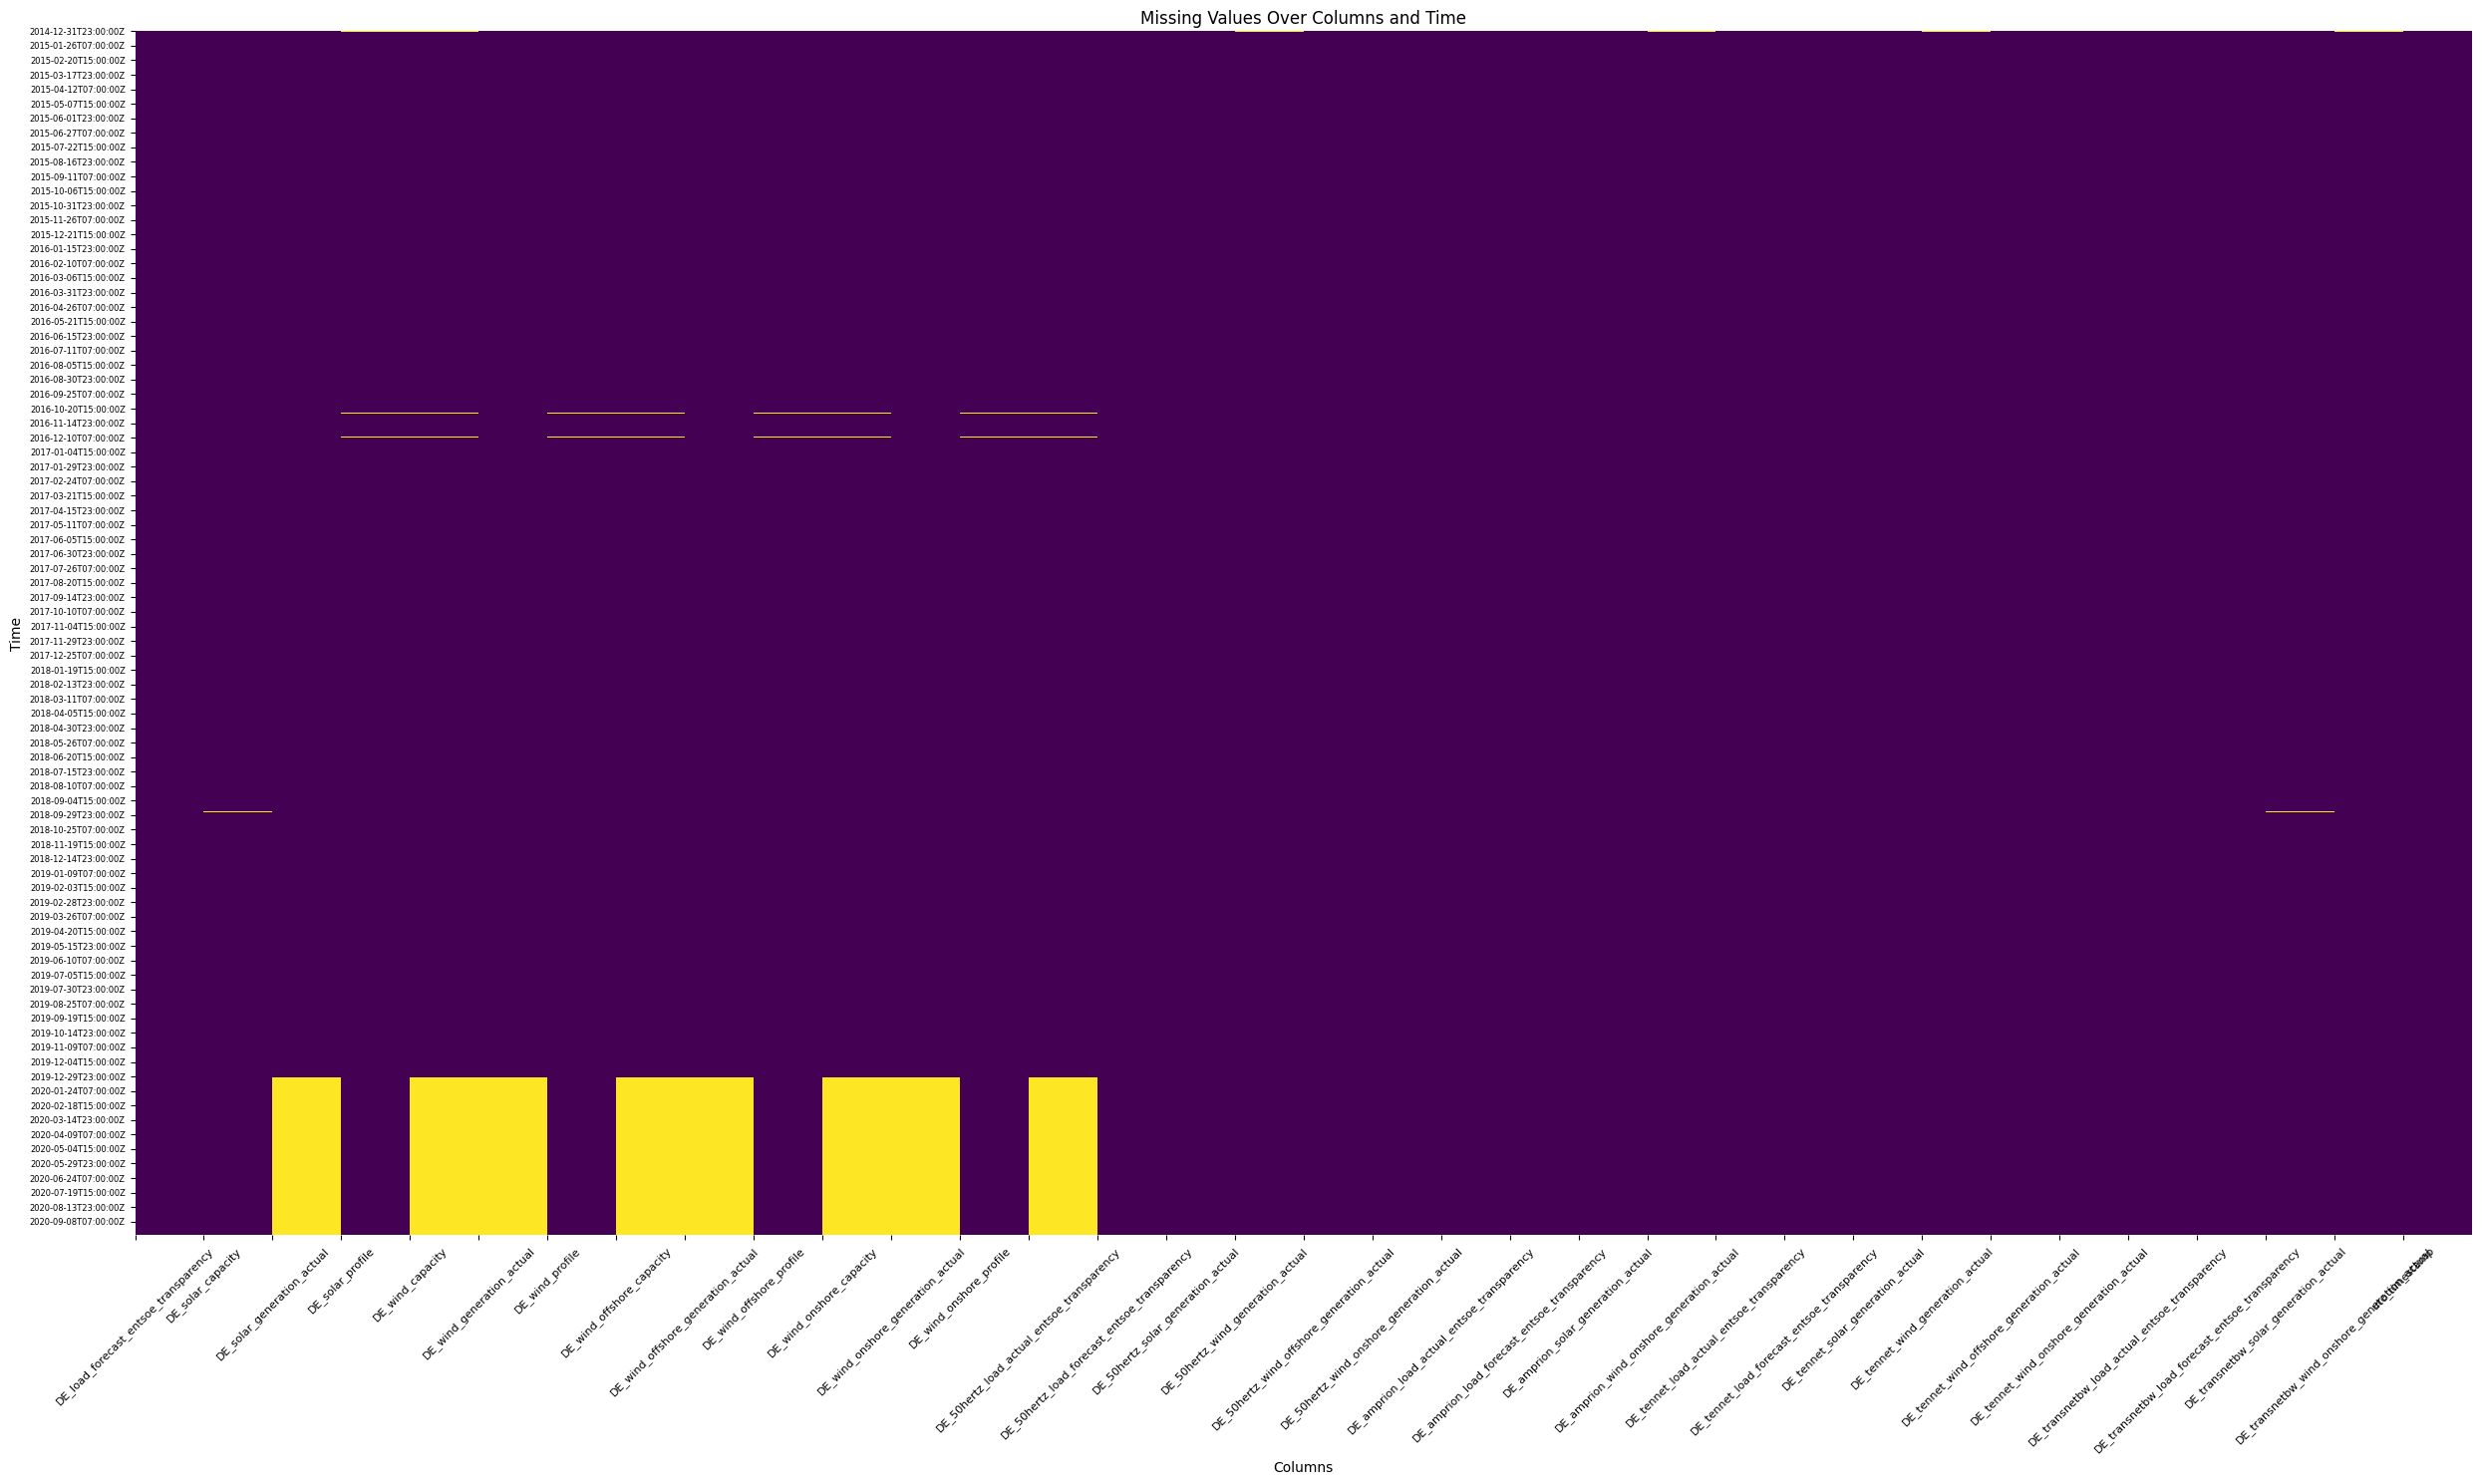

In [6]:
# Create a heatmap of missing values over time
plt.figure(figsize=(25, 15))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Over Columns and Time')
plt.xlabel('Columns')
plt.ylabel('Time')
plt.xticks(range(len(filtered_columns) - 1), filtered_columns[1:], rotation=45, fontsize=8)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

In [7]:
# Check for missing values in 'DE_wind_onshore_profile' column and get the index of the first missing value to see the exact date where the many missing values start
first_missing_index = df['DE_wind_capacity'].isnull().idxmax()

print("Index of the first missing value in 'DE_wind_onshore_generation_actual':", first_missing_index)

Index of the first missing value in 'DE_wind_onshore_generation_actual': 2019-12-30T23:00:00Z


There is a clear pattern that after 30.12.2019 some aggregate statistics are missing. Since there are still enough training data and later on the amount of data that the GPU can handle is limited. The data will just be cut off.

/tmp/ipykernel_28020/1459868856.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sorted_columnss = sorted_columns.append(pd.Series([0]))


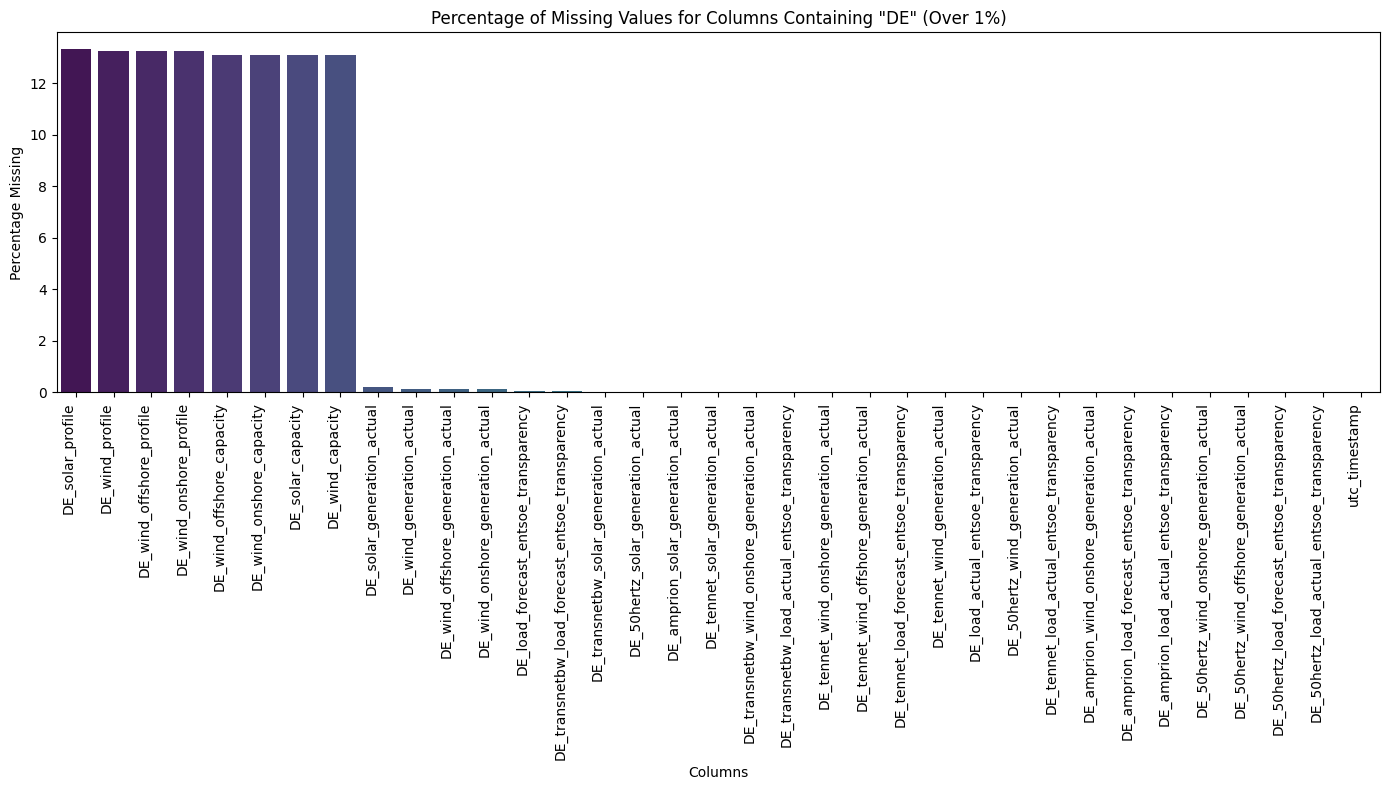

In [8]:
sorted_columns = missing_values_percentage.sort_values(ascending=False)
# Add an empty label at the beginning to align with the first column just for a nice visualization
sorted_columnss = sorted_columns.append(pd.Series([0]))
# Create a bar plot of missing values percentage with adjusted figure size and rotated labels
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=sorted_columns.index, y=sorted_columns.values, palette="viridis")
plt.title('Percentage of Missing Values for Columns Containing "DE" (Over 1%)')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=90, ha='right') 

plt.tight_layout()
plt.show()

In [9]:
# Count missing values and return the aggregated sum
missing_values_count = df.isnull().sum().sum()

print("Total missing values:", missing_values_count)

Total missing values: 53580


In [10]:
df = df.rename_axis('date')

In [11]:
df.index = pd.to_datetime(df.index)

In [12]:
cutoff_date = pd.to_datetime('2019-12-30T23:00:00Z')
df = df[df.index <= cutoff_date]

Since Germany is divided into 4 different energy zones, that are then accumulated to total Germany. The columns partially have high collinearity. This is quite logical since for instance the solar_production in the amprion region and the solar_production in the transnet region will follow a similar pattern because most often the weather is similar.

In [13]:
# Count missing values and return the aggregated sum
missing_values_count = df.isnull().sum().sum()

print("Total missing values:", missing_values_count)

Total missing values: 760


In [14]:
total_values = df.size
percentage_missing = (missing_values_count / total_values) * 100
print(f"Percentage of Missing Values: {percentage_missing:.2f}%")


Percentage of Missing Values: 0.05%


In [15]:
# There are still around 0.05% of missing values, which are filled by simple linear interpolation
df.interpolate(method='linear', axis=0, inplace=True)

In [16]:
# All remaining missing values are in the first 8 rows of the dataframe, hence no interpolation is possible -> drop those rows
df = df.iloc[8:]

In [17]:
# Count missing values and return the aggregated sum
missing_values_count = df.isnull().sum().sum()

print("Total missing values:", missing_values_count)

Total missing values: 0


## 2. Create Datasets
Since the dataset is already preprocessed by the original authors. We do not need to worry about outliers, wrong data or the change of summertime and wintertime. 

In [18]:
df = df.reset_index()

In [19]:
# Remove columns containing 'load_forecast' in the column name
columns_to_remove = [col for col in df.columns if 'load_forecast' in col]
df = df.drop(columns=columns_to_remove)

In [20]:
# Reformat the datetime column to remove the timezone
df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['date'] = df['date'].astype(object)

In [61]:
df.to_csv('01_datasets/df_all_columns.csv', index=False)

In [60]:
# This reduces the dataset only to the columns that contain load or wind and solar generation
columns_to_remove = [col for col in df.columns if 'capacity' in col or 'profile' in col]
df_only_generation = df.drop(columns=columns_to_remove)

In [65]:
df_only_generation.to_csv('01_datasets/df_only_generation_columns.csv', index=False)

In [63]:
# This reduces the dataset only to the Germany wide load, solar and wind generation
df_most_important_columns = df[['date','DE_load_actual_entsoe_transparency', 'DE_solar_generation_actual', 'DE_wind_generation_actual']]

In [29]:
df_most_important_columns.to_csv('01_datasets/df_most_important_columns.csv', index=False)

## 3. Analyze data

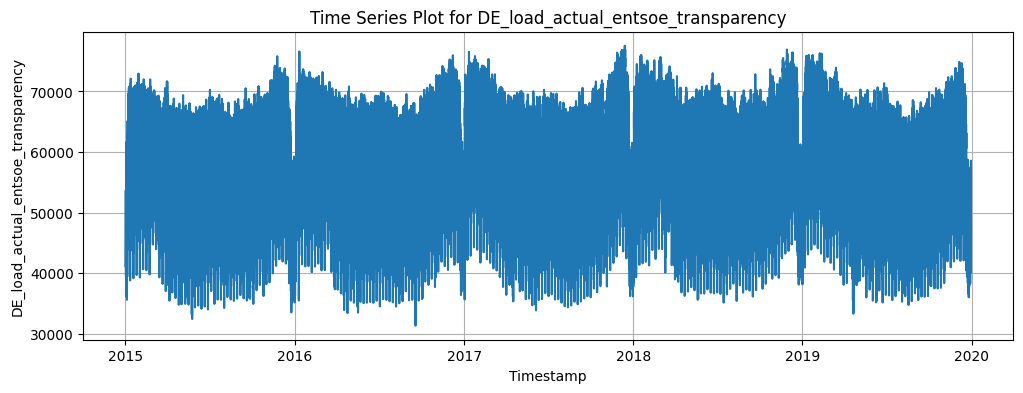

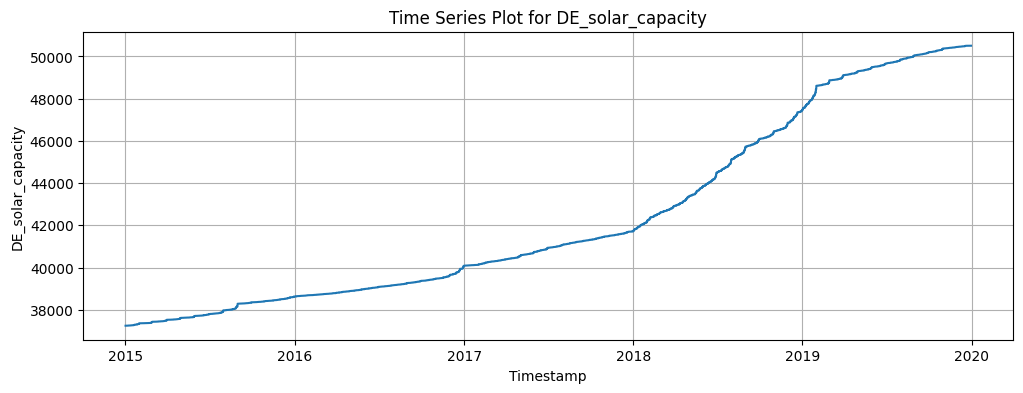

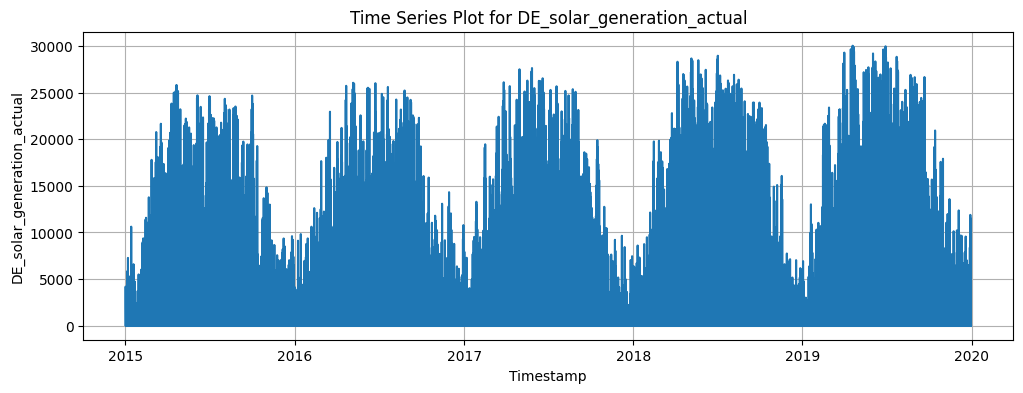

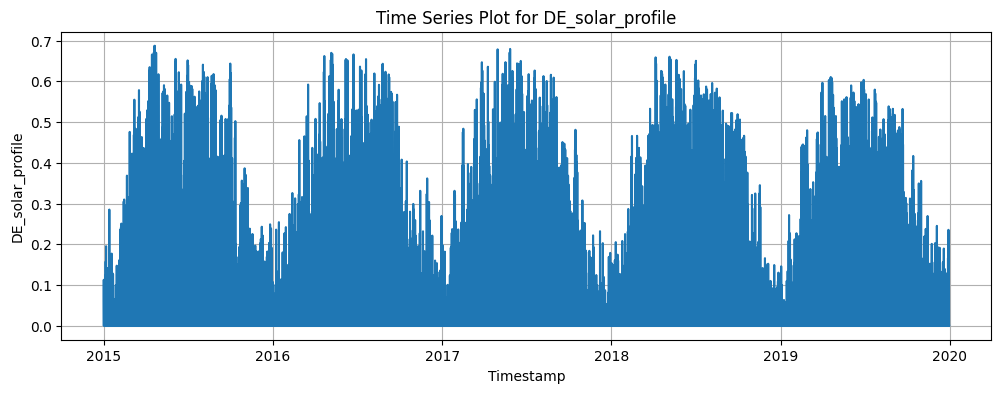

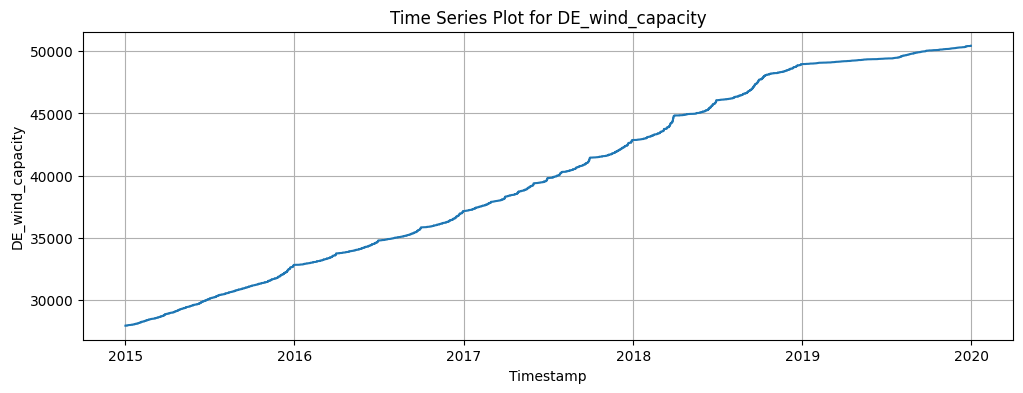

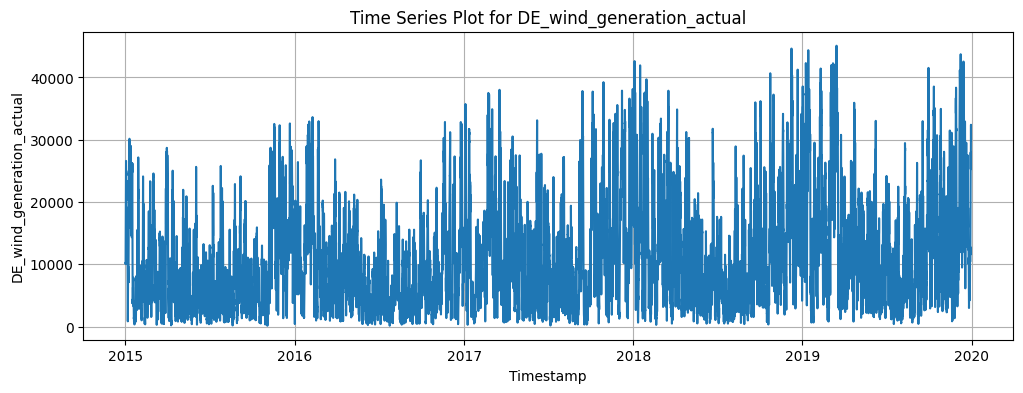

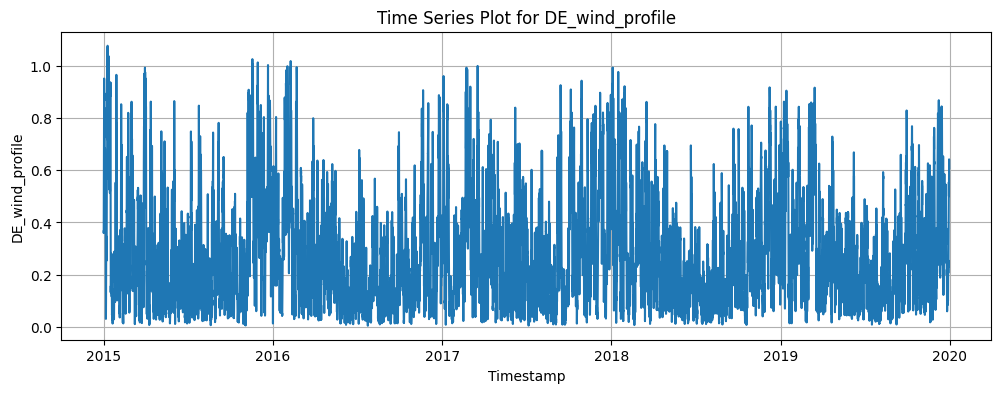

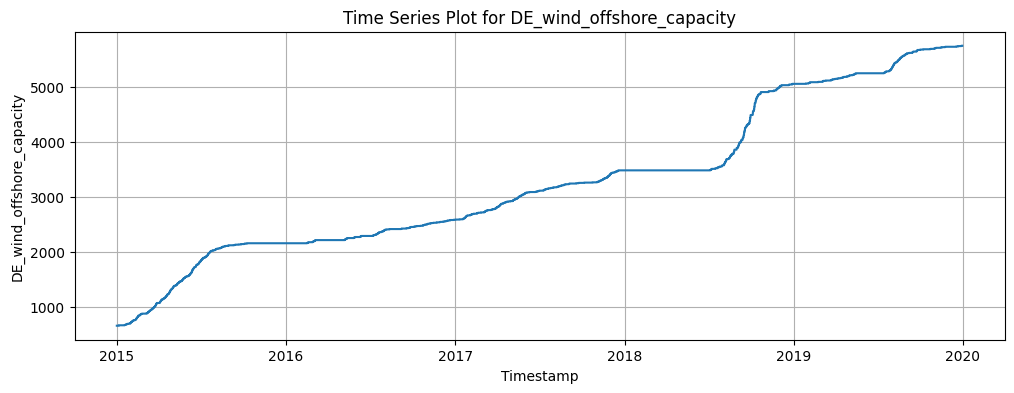

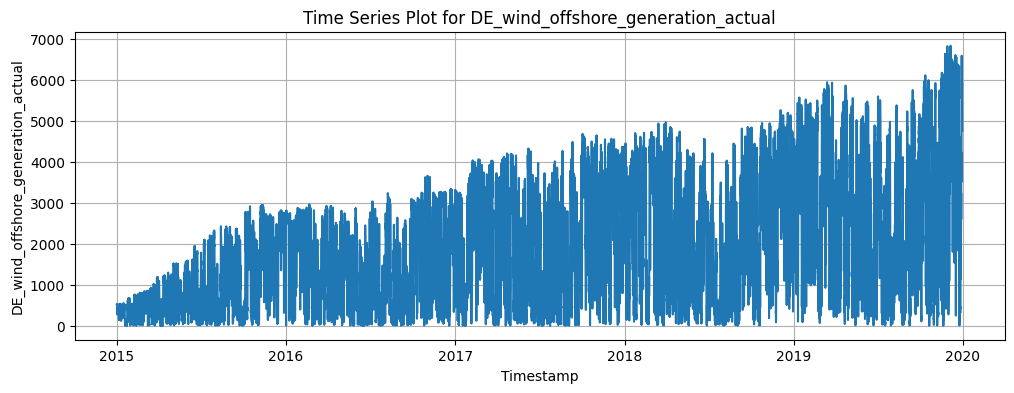

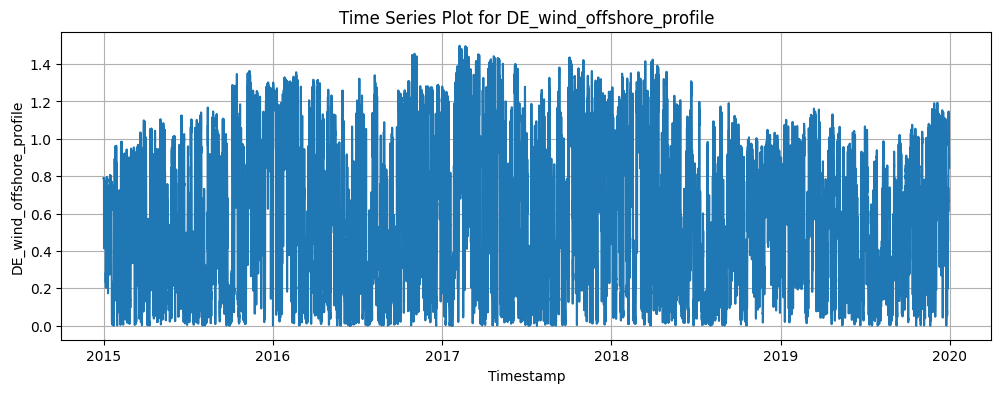

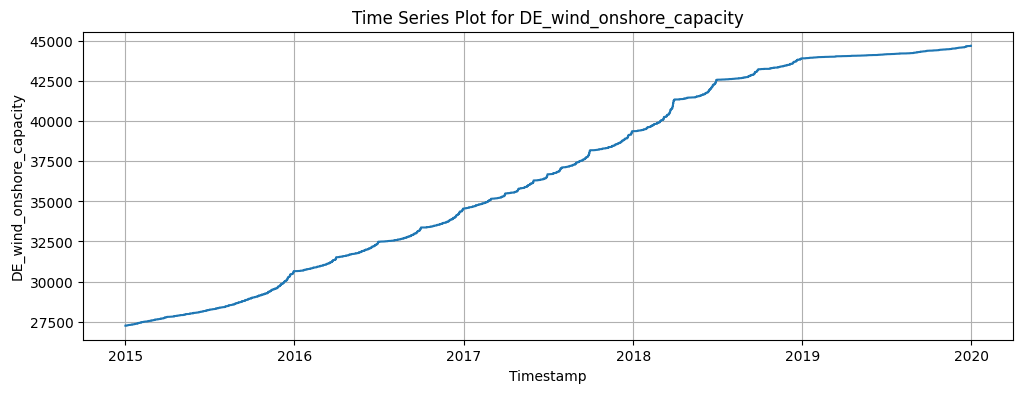

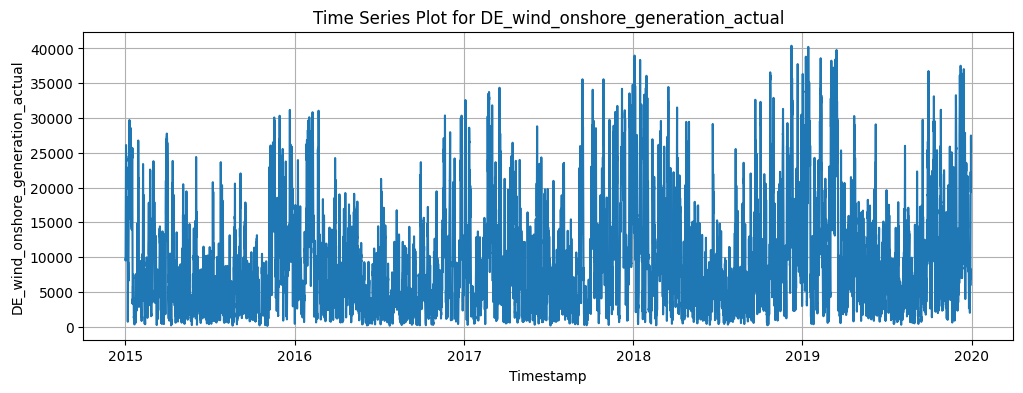

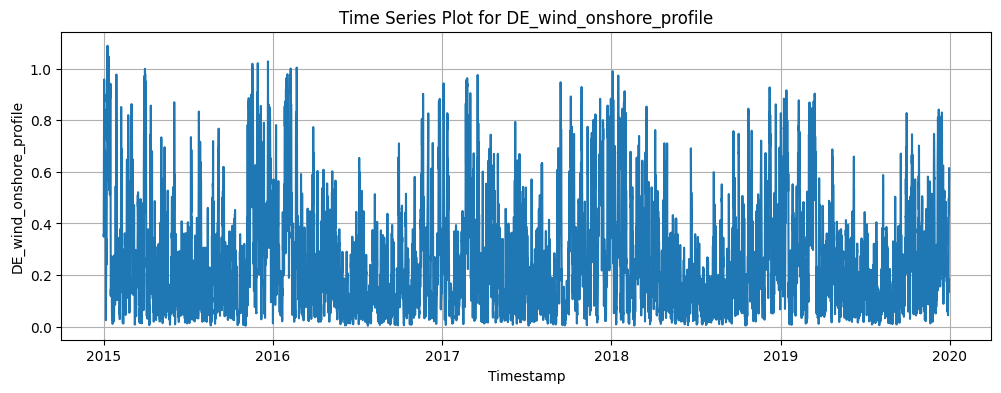

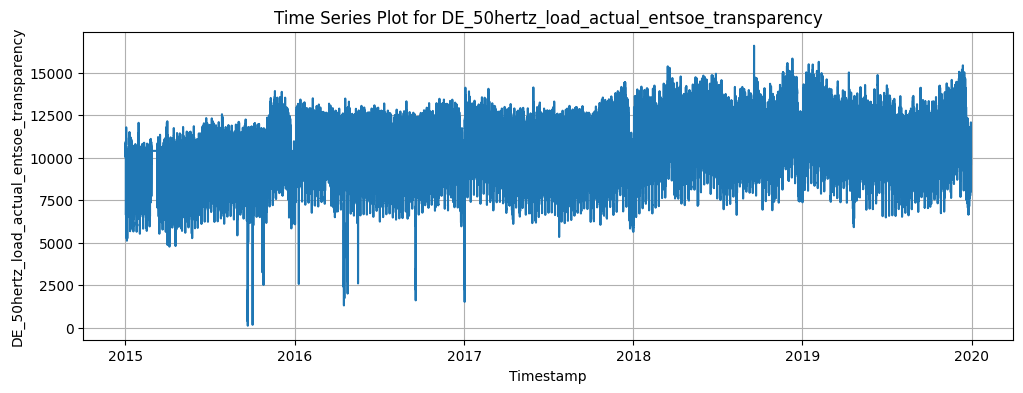

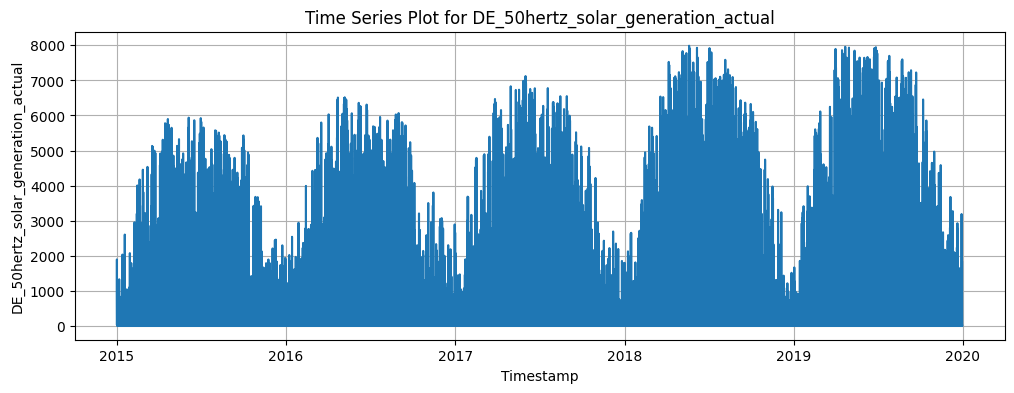

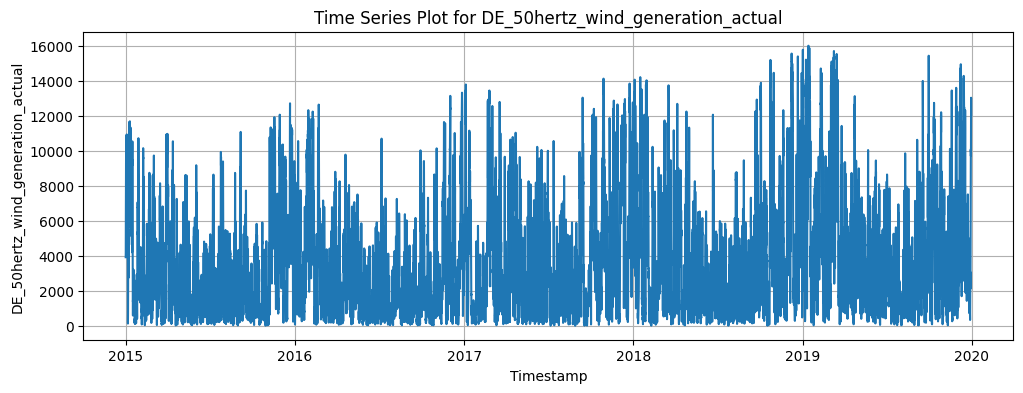

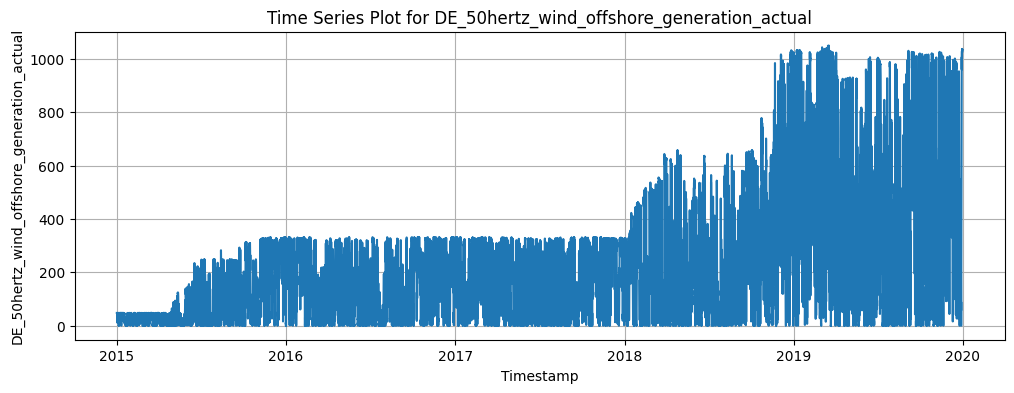

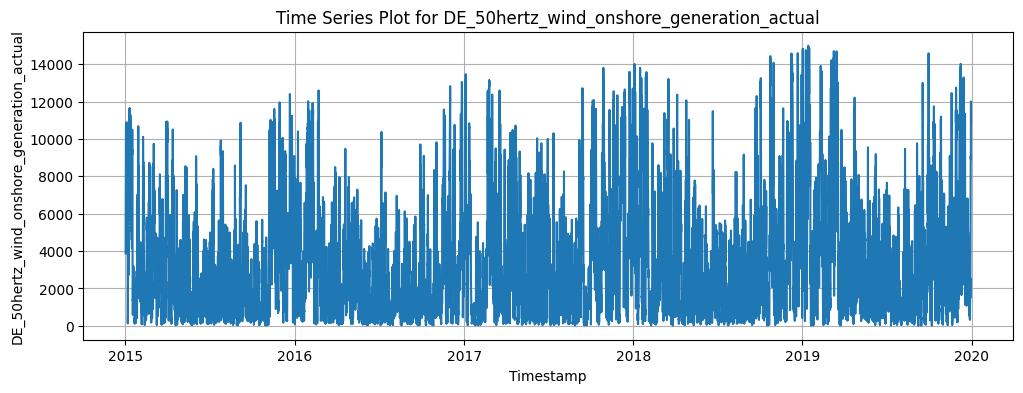

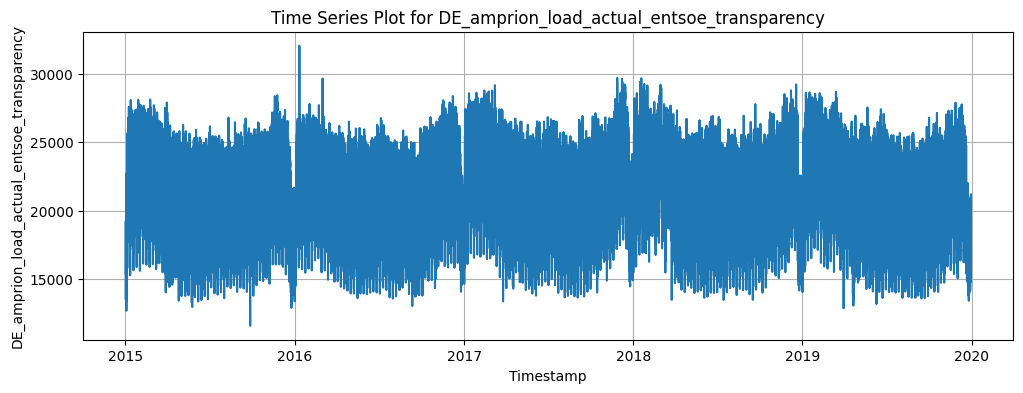

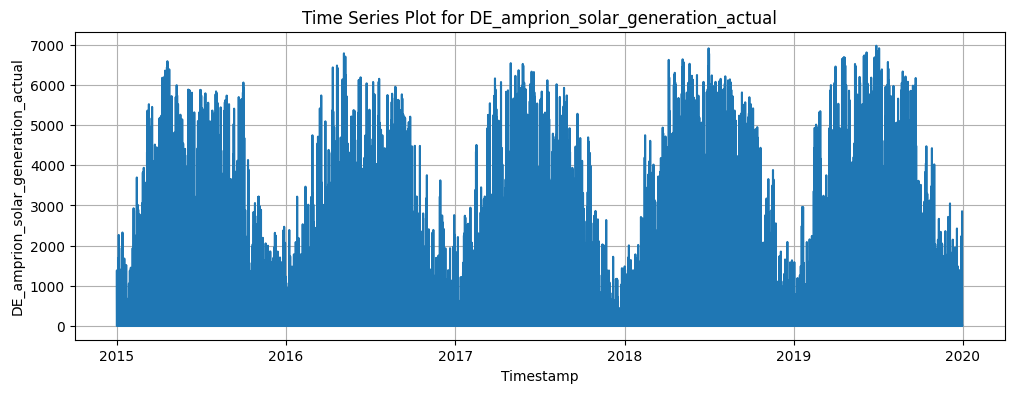

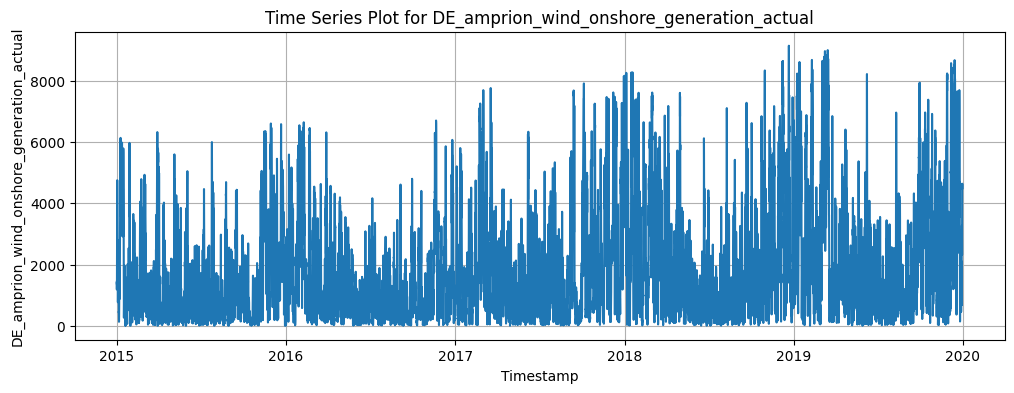

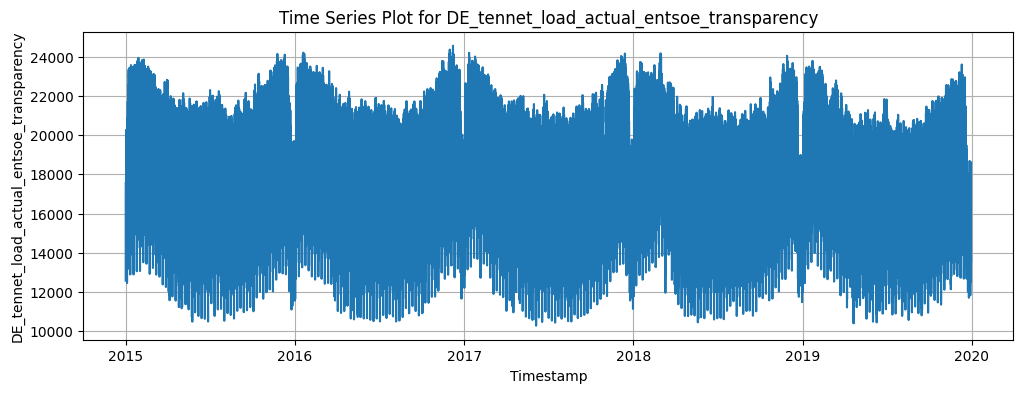

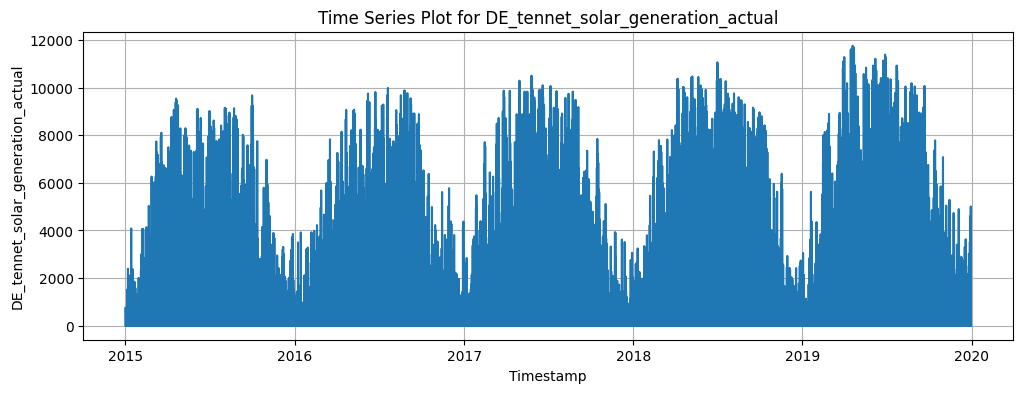

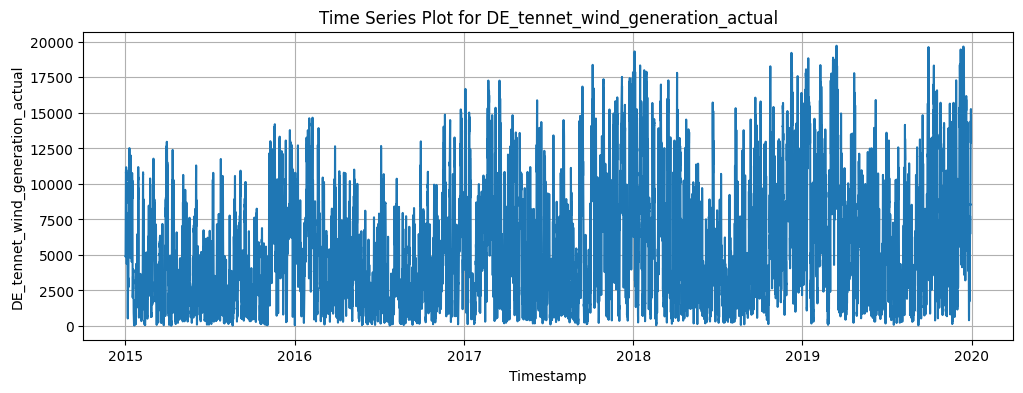

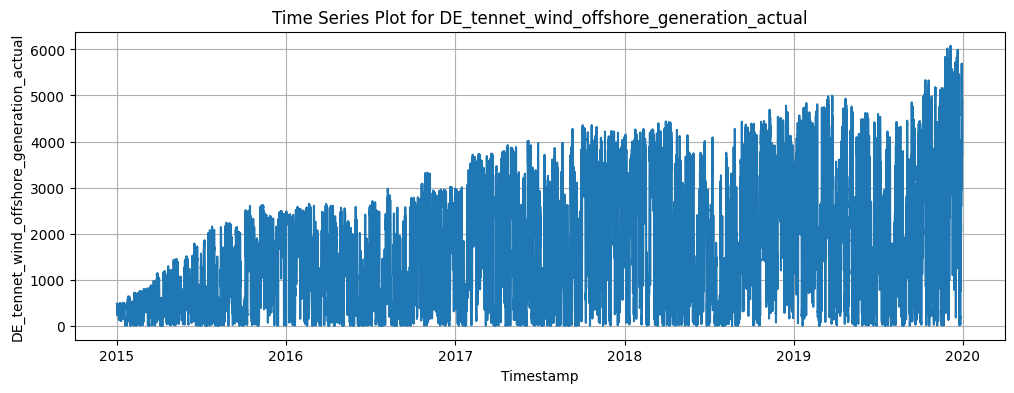

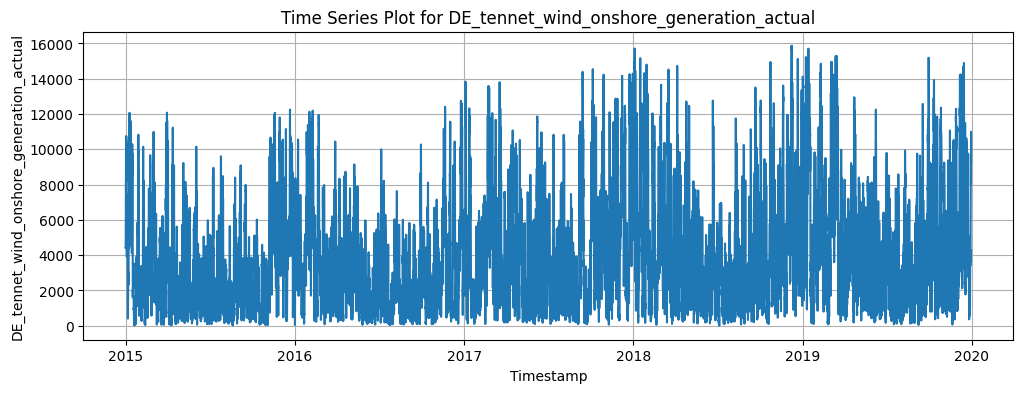

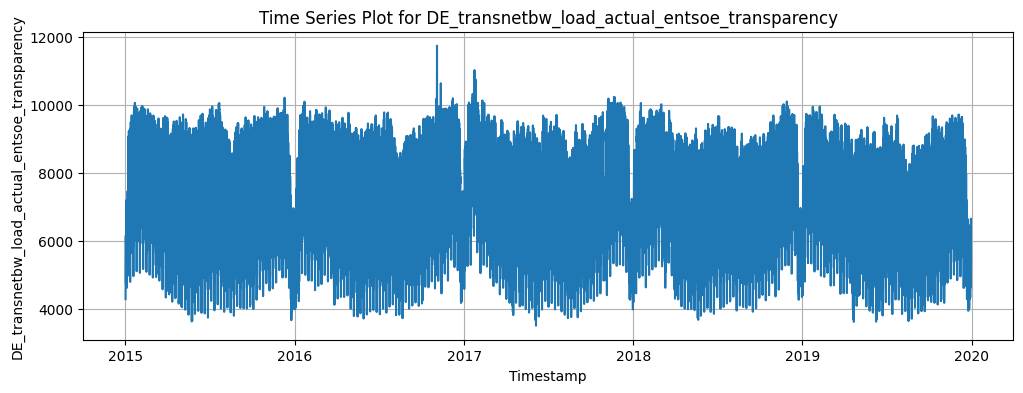

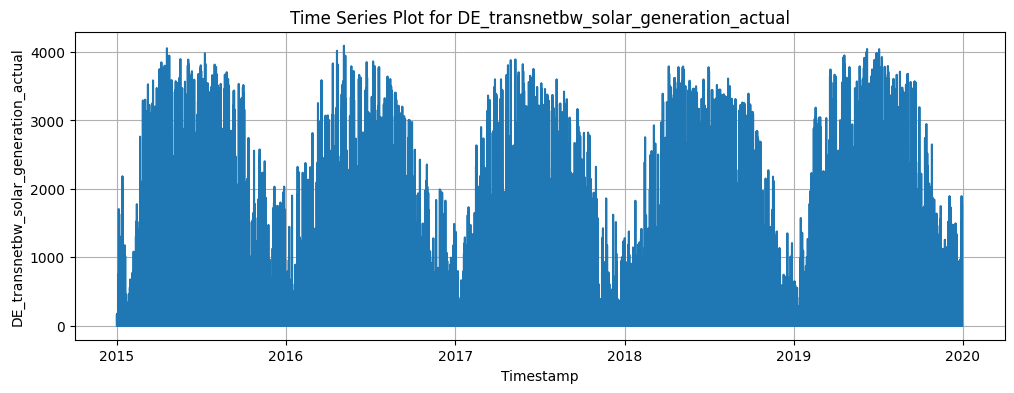

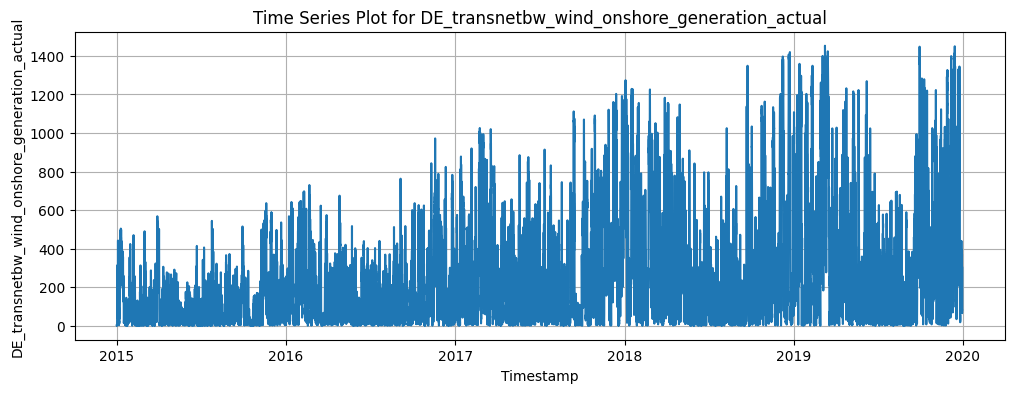

In [70]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Plot each variable separately over time
for column in df.columns:
    plt.figure(figsize=(12, 4))
    plt.title(f'Time Series Plot for {column}')
    sns.lineplot(data=df[column], x=df.index, y=df[column])
    plt.xlabel('Timestamp')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

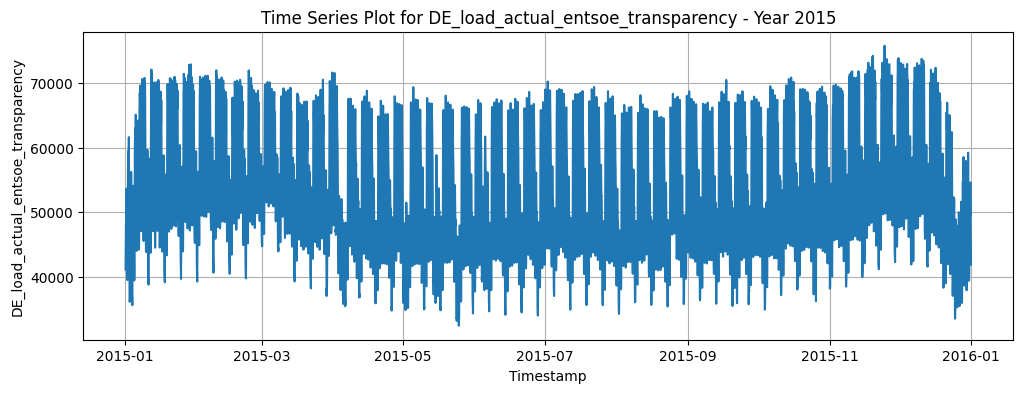

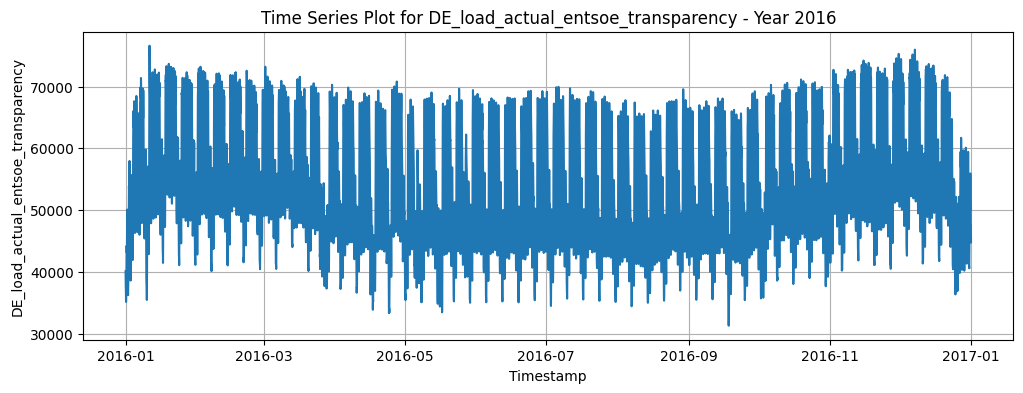

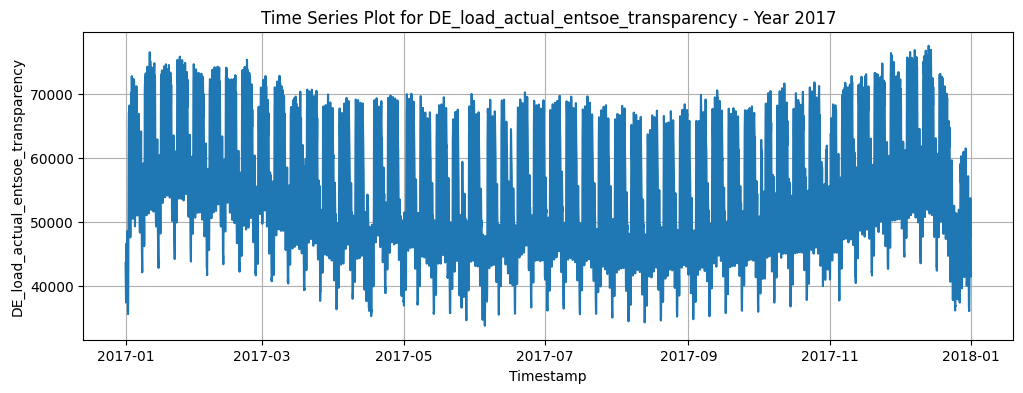

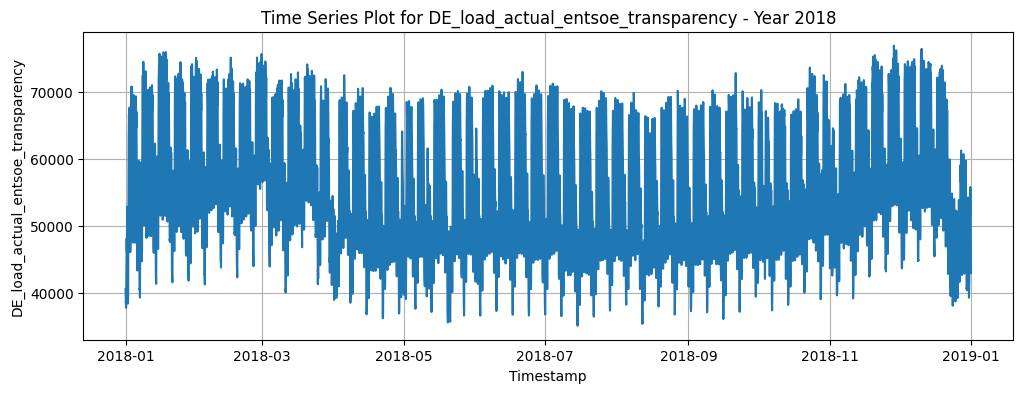

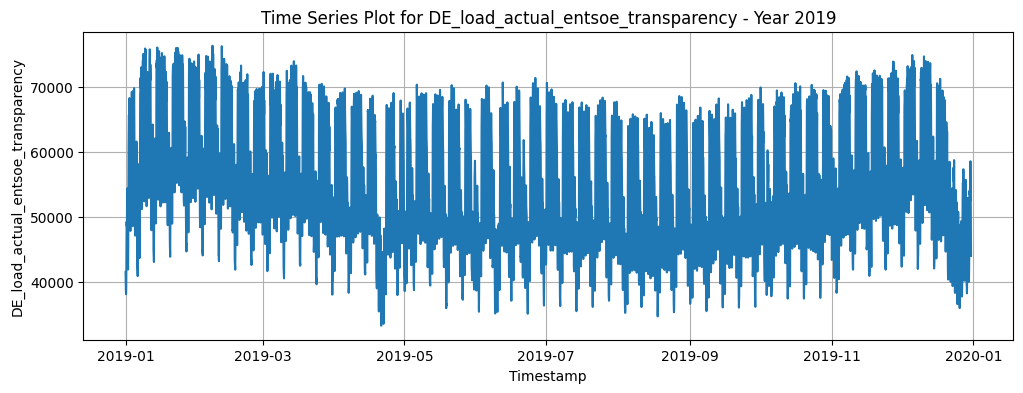

In [71]:
# Plot the Load for each year separately
df['year'] = df.index.year
column_name = 'DE_load_actual_entsoe_transparency'

# Group the data by year and create individual plots for each year
for year, group_data in df.groupby('year'):
    plt.figure(figsize=(12, 4))
    plt.title(f'Time Series Plot for {column_name} - Year {year}')
    sns.lineplot(data=group_data, x=group_data.index, y=column_name)
    plt.xlabel('Timestamp')
    plt.ylabel(column_name)
    plt.grid(True)
    plt.show()

In [72]:
column_name = 'DE_load_actual_entsoe_transparency'

# Calculate the correlation between values and their corresponding values one year ago for load
correlation = df[column_name].corr(df[column_name].shift(365), method='pearson')

print(f"Pearson Correlation Coefficient (Overall): {correlation}")

Pearson Correlation Coefficient (Overall): 0.17398421056609914


<Figure size 1200x400 with 0 Axes>

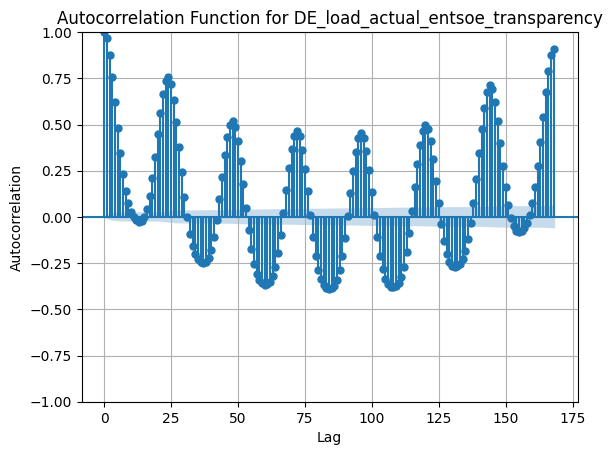

<Figure size 1200x400 with 0 Axes>

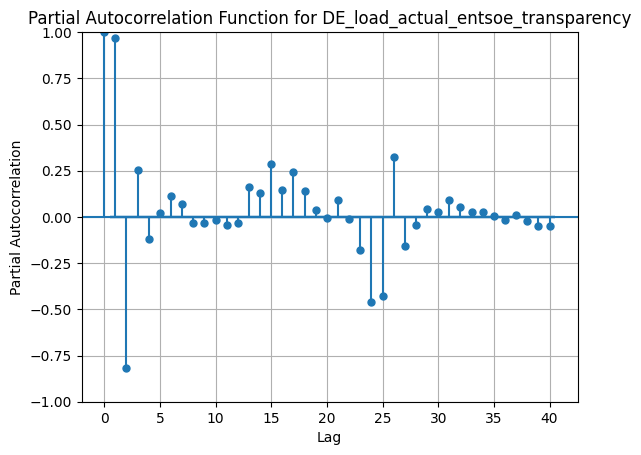

<Figure size 1200x400 with 0 Axes>

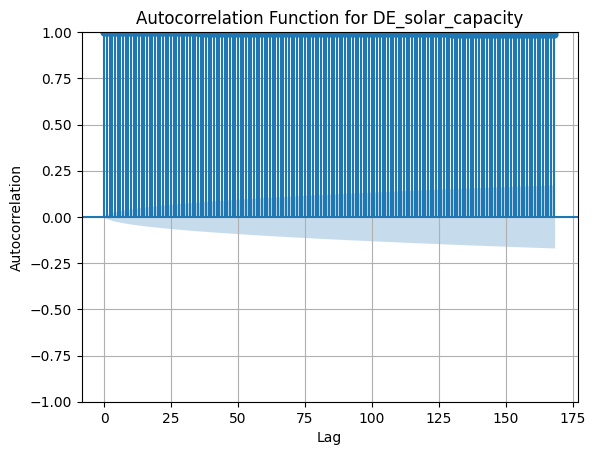

<Figure size 1200x400 with 0 Axes>

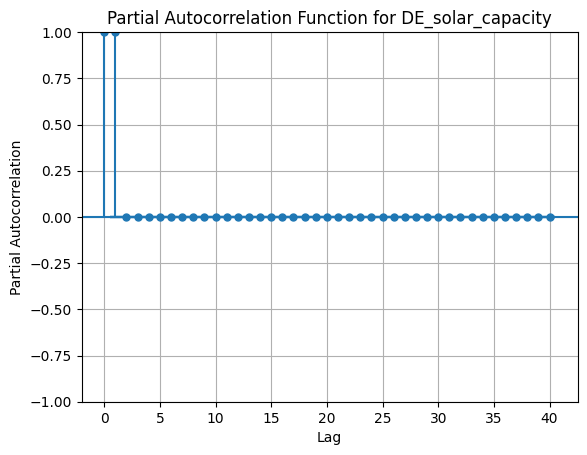

<Figure size 1200x400 with 0 Axes>

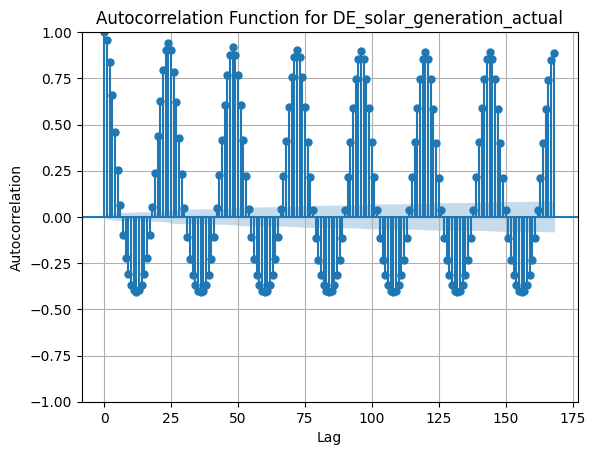

<Figure size 1200x400 with 0 Axes>

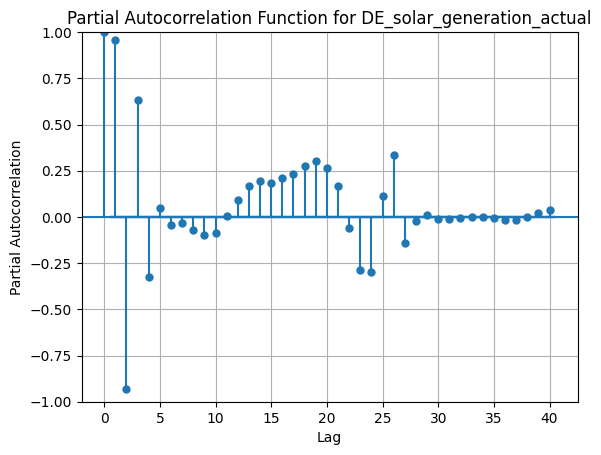

<Figure size 1200x400 with 0 Axes>

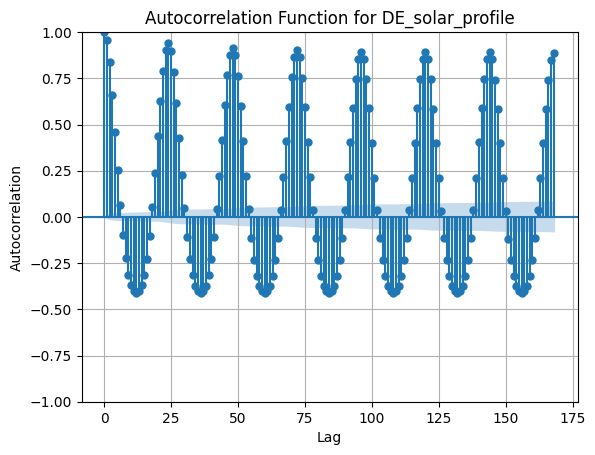

<Figure size 1200x400 with 0 Axes>

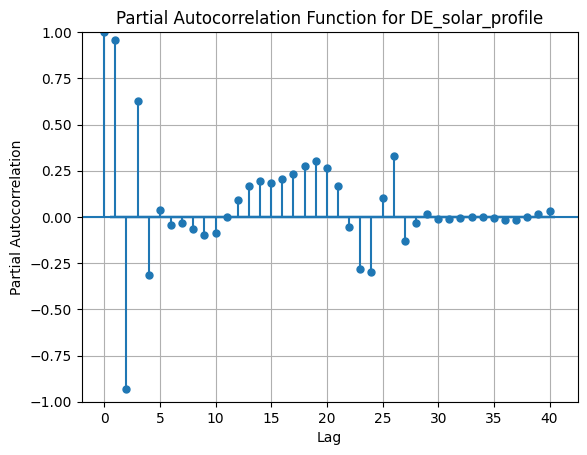

<Figure size 1200x400 with 0 Axes>

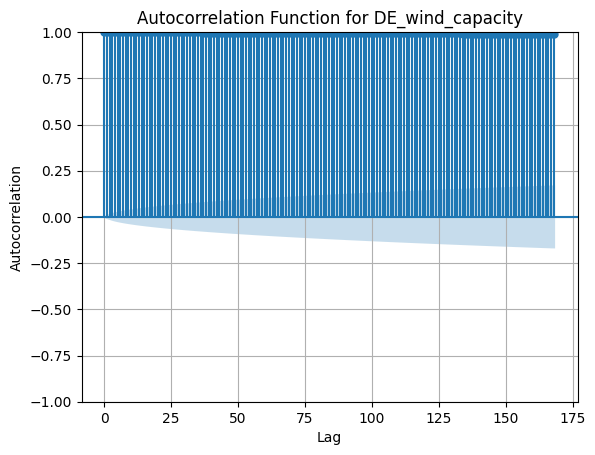

<Figure size 1200x400 with 0 Axes>

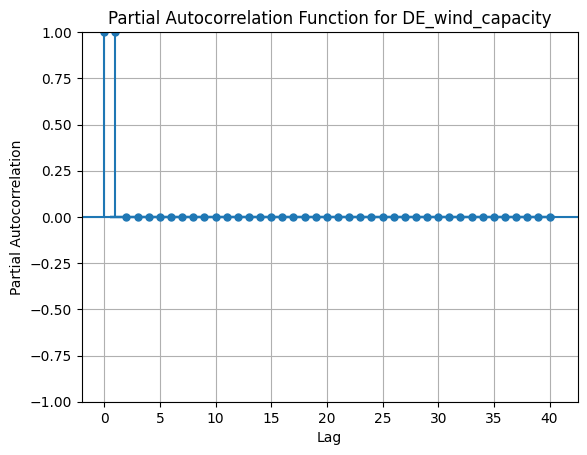

<Figure size 1200x400 with 0 Axes>

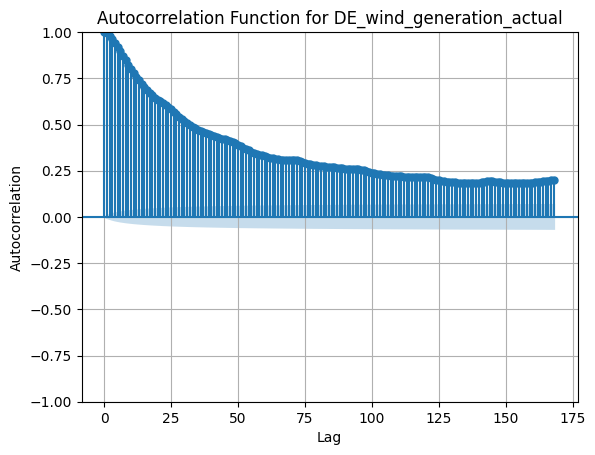

<Figure size 1200x400 with 0 Axes>

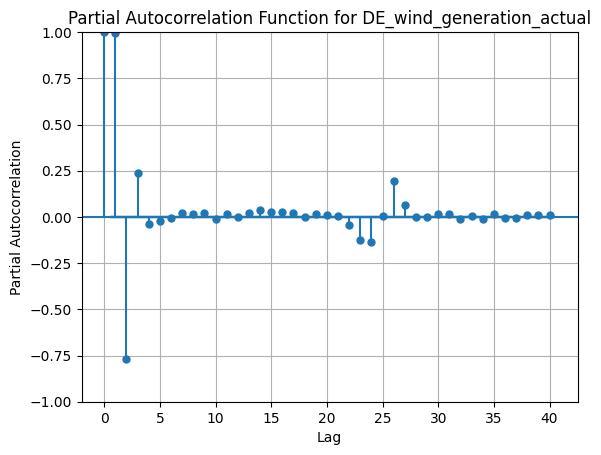

<Figure size 1200x400 with 0 Axes>

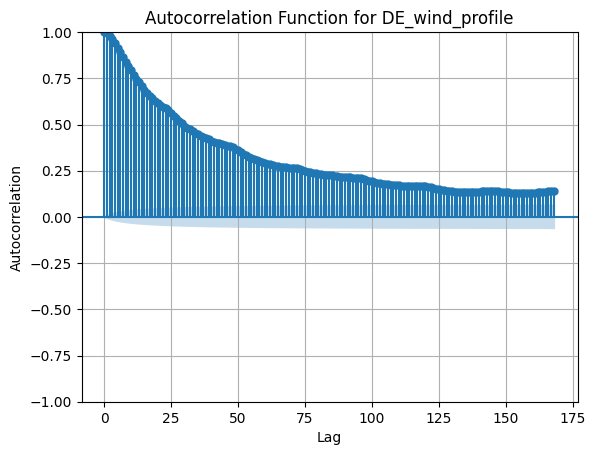

<Figure size 1200x400 with 0 Axes>

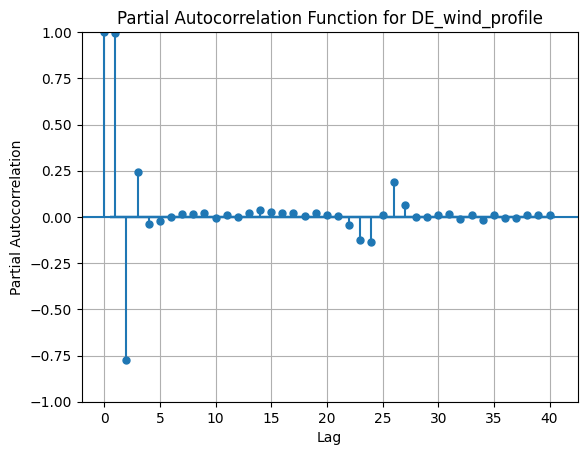

<Figure size 1200x400 with 0 Axes>

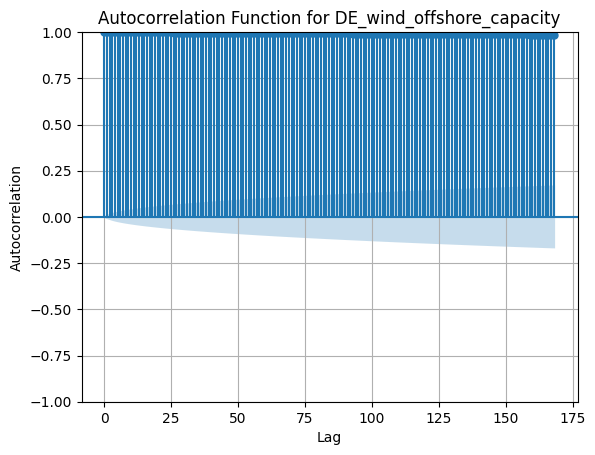

<Figure size 1200x400 with 0 Axes>

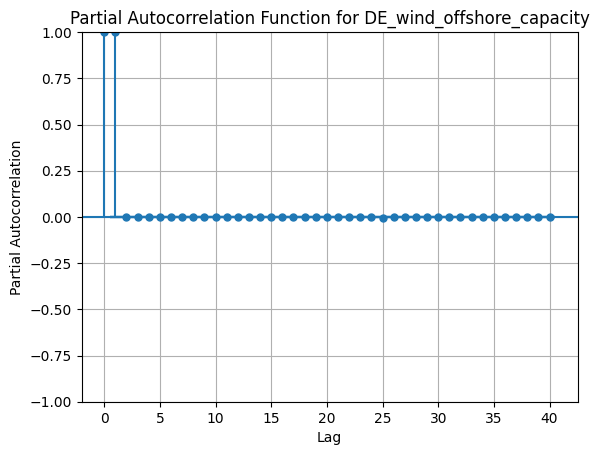

<Figure size 1200x400 with 0 Axes>

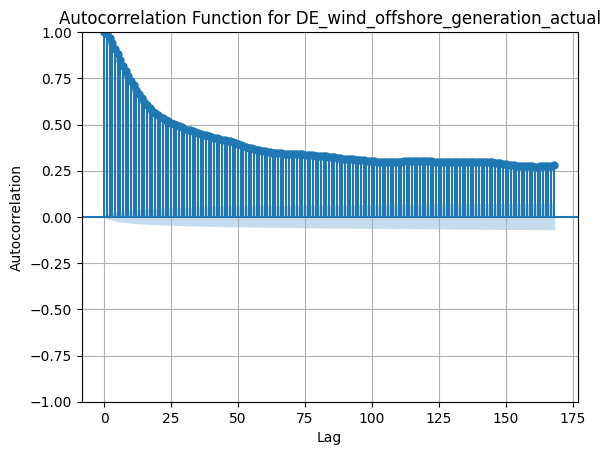

<Figure size 1200x400 with 0 Axes>

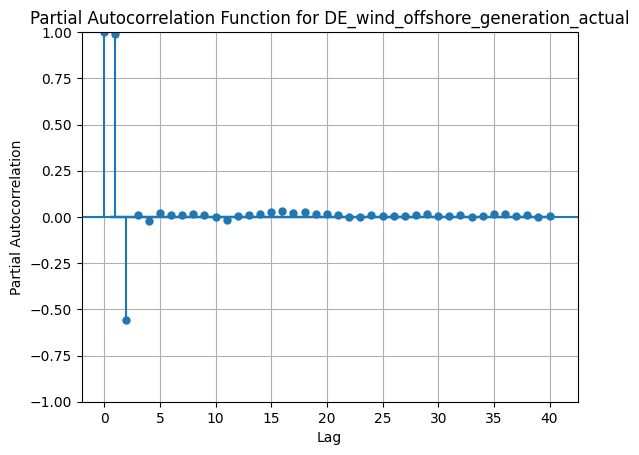

<Figure size 1200x400 with 0 Axes>

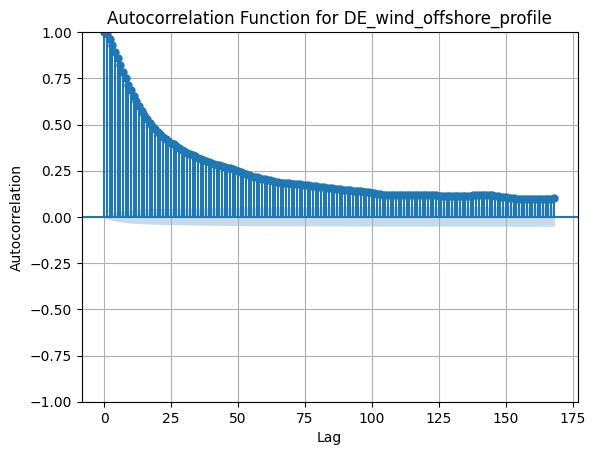

<Figure size 1200x400 with 0 Axes>

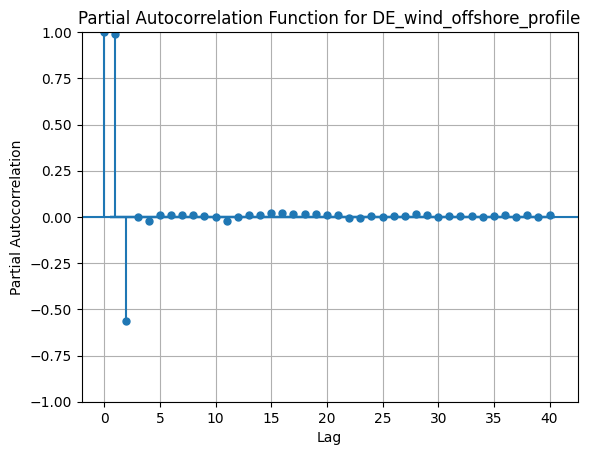

<Figure size 1200x400 with 0 Axes>

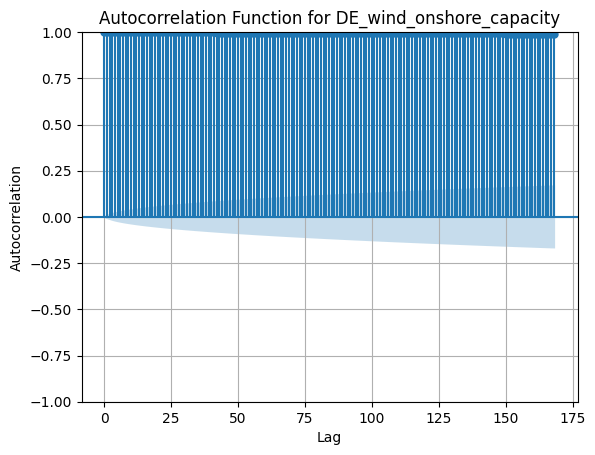

<Figure size 1200x400 with 0 Axes>

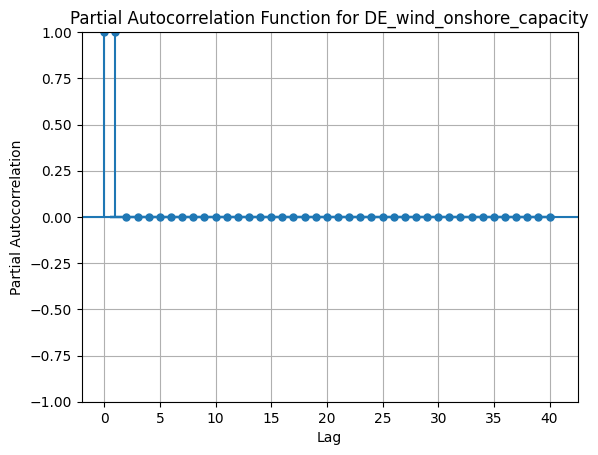

<Figure size 1200x400 with 0 Axes>

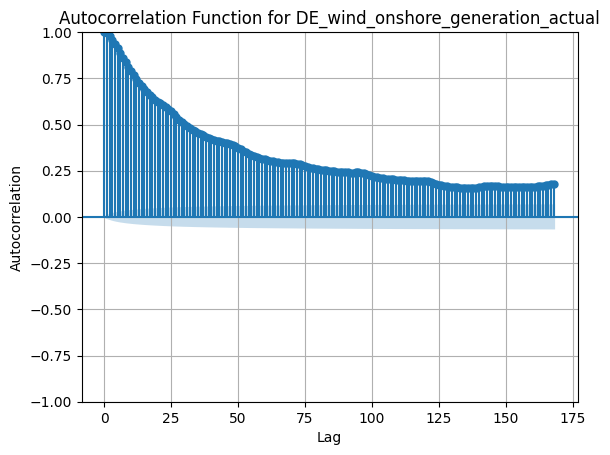

<Figure size 1200x400 with 0 Axes>

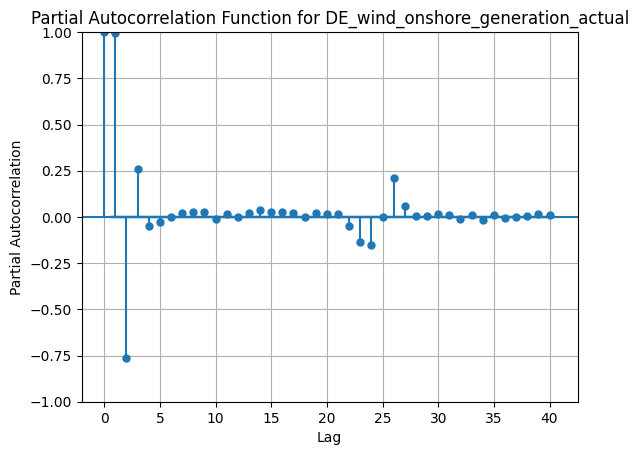

<Figure size 1200x400 with 0 Axes>

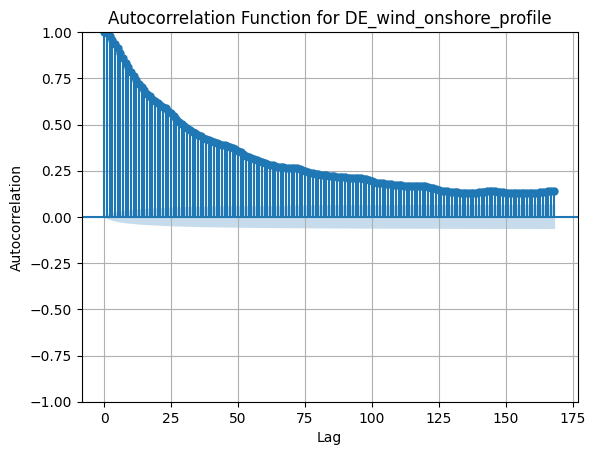

<Figure size 1200x400 with 0 Axes>

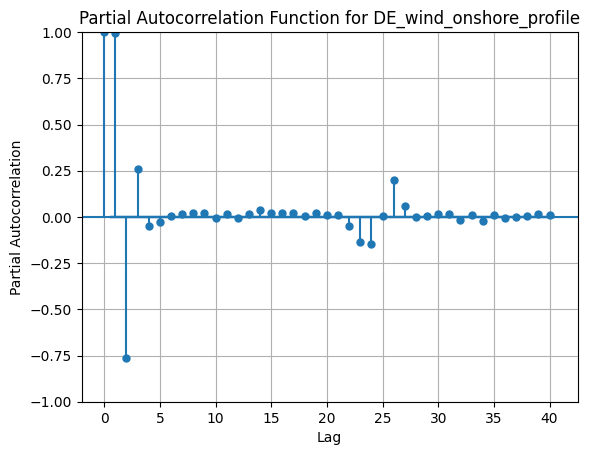

<Figure size 1200x400 with 0 Axes>

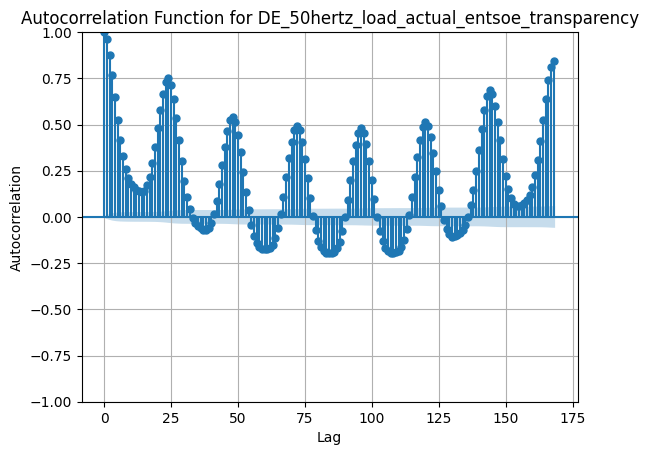

<Figure size 1200x400 with 0 Axes>

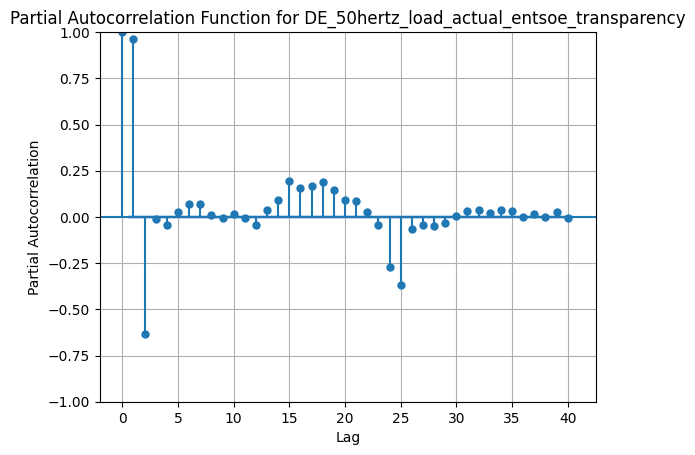

<Figure size 1200x400 with 0 Axes>

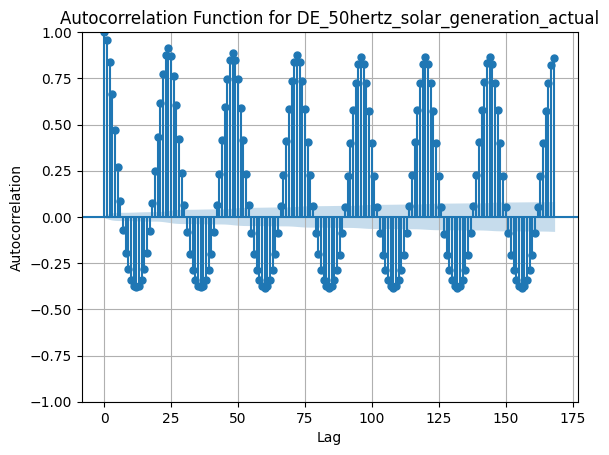

<Figure size 1200x400 with 0 Axes>

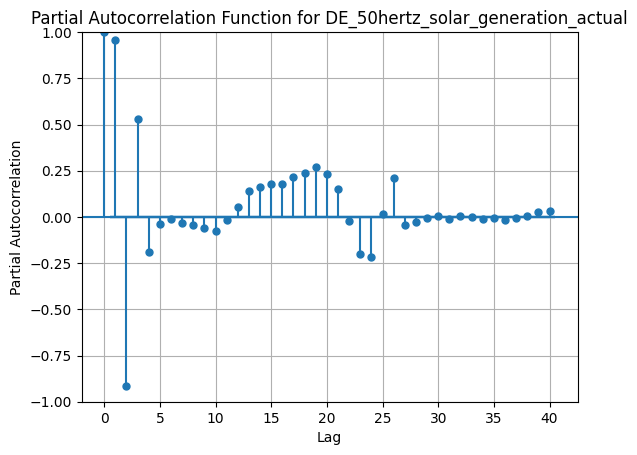

<Figure size 1200x400 with 0 Axes>

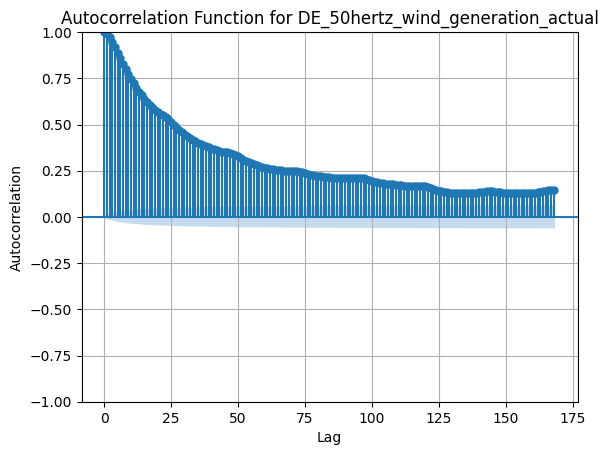

<Figure size 1200x400 with 0 Axes>

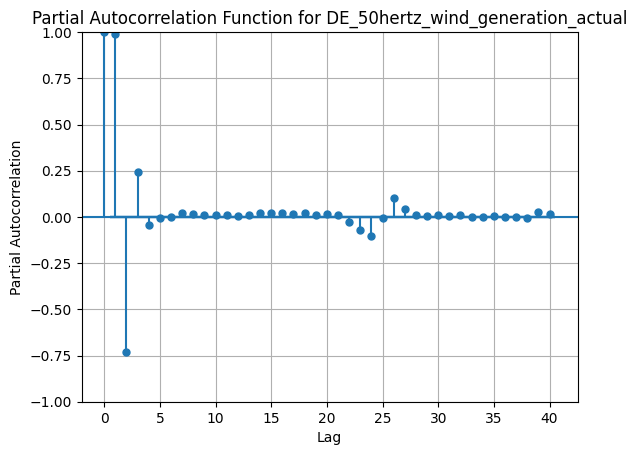

<Figure size 1200x400 with 0 Axes>

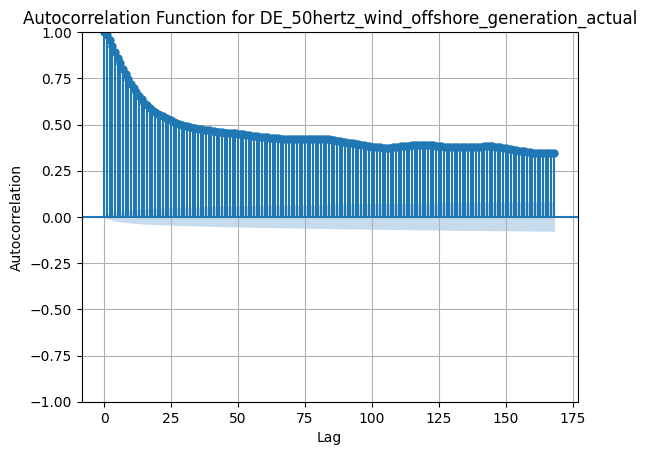

<Figure size 1200x400 with 0 Axes>

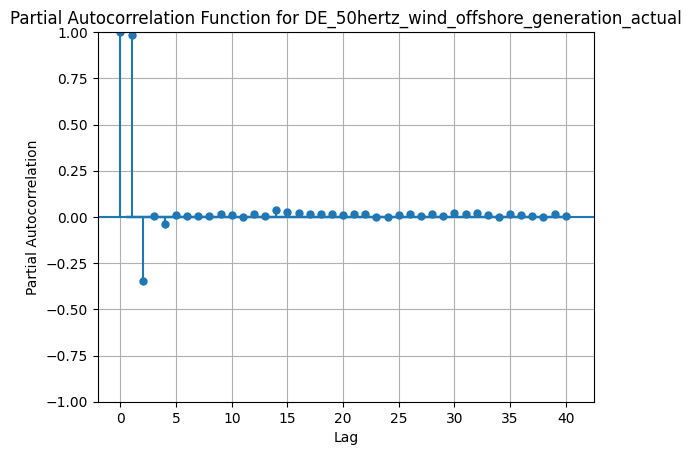

<Figure size 1200x400 with 0 Axes>

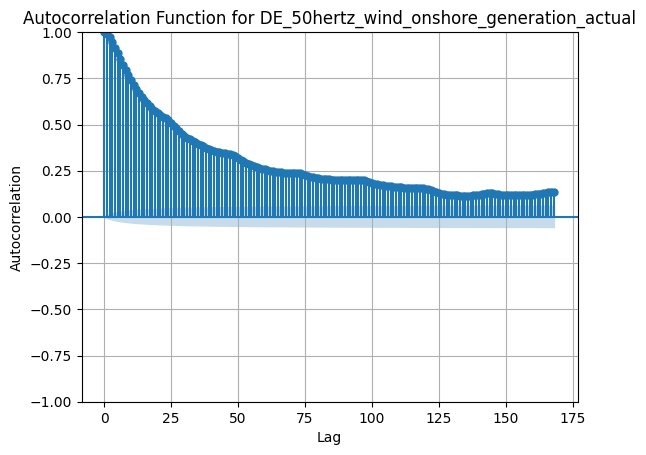

<Figure size 1200x400 with 0 Axes>

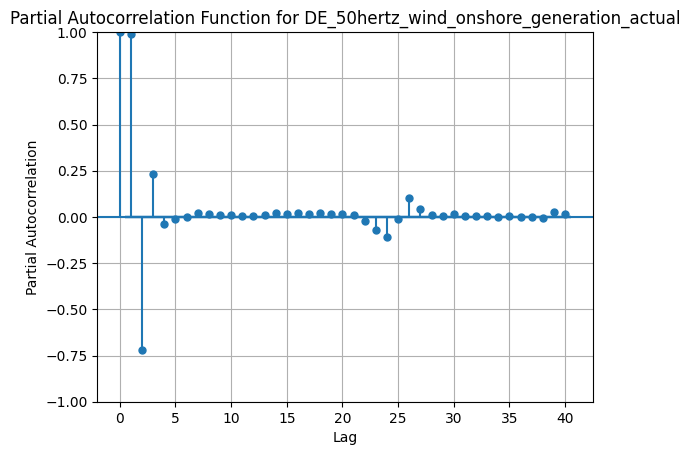

<Figure size 1200x400 with 0 Axes>

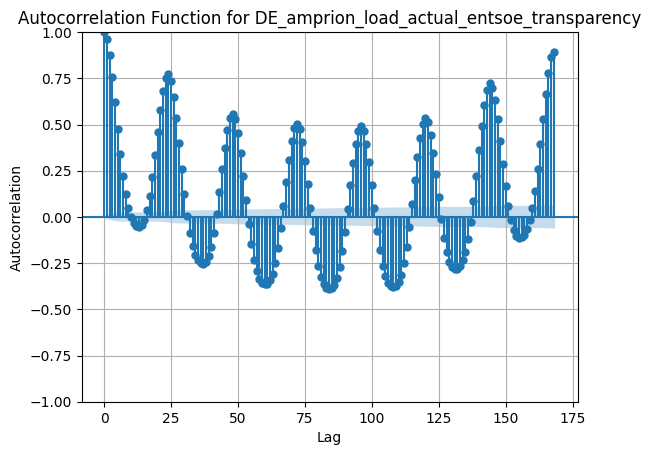

<Figure size 1200x400 with 0 Axes>

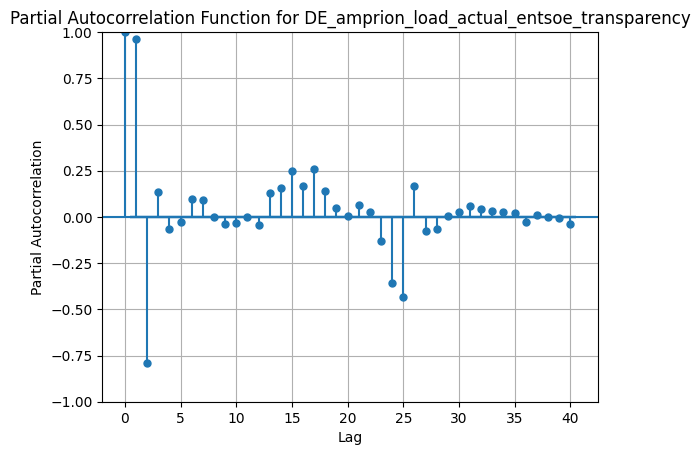

<Figure size 1200x400 with 0 Axes>

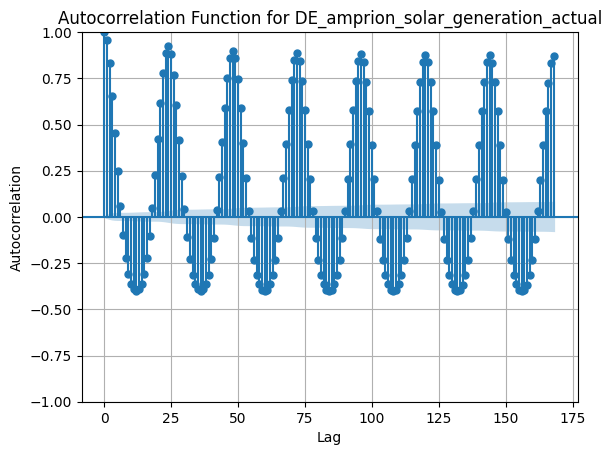

<Figure size 1200x400 with 0 Axes>

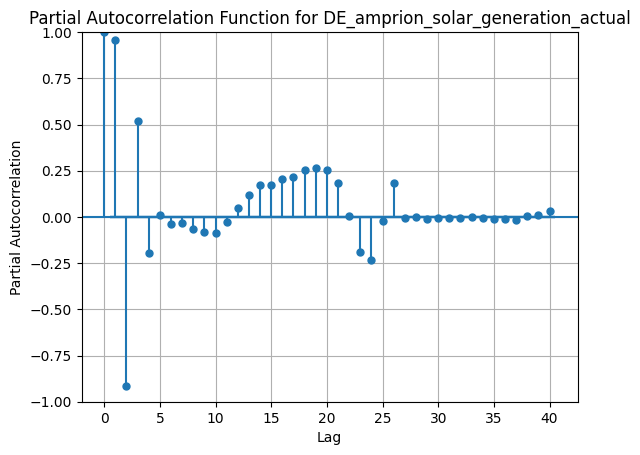

<Figure size 1200x400 with 0 Axes>

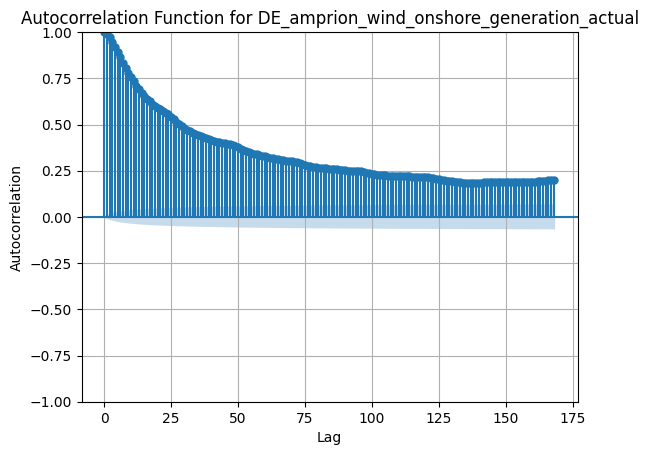

<Figure size 1200x400 with 0 Axes>

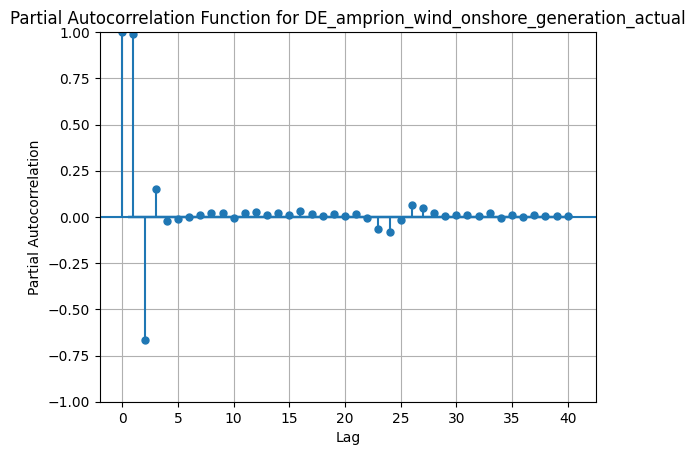

<Figure size 1200x400 with 0 Axes>

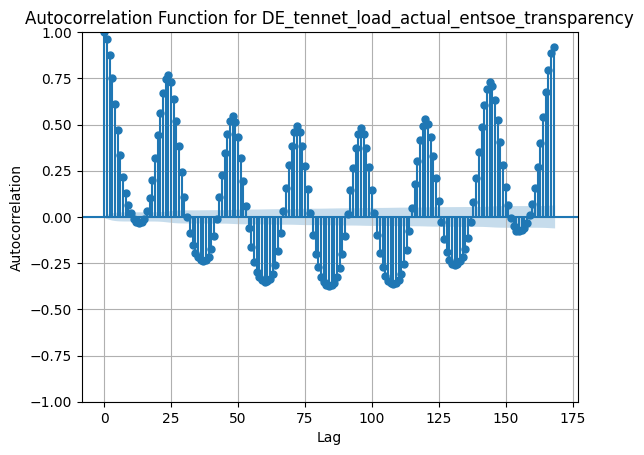

<Figure size 1200x400 with 0 Axes>

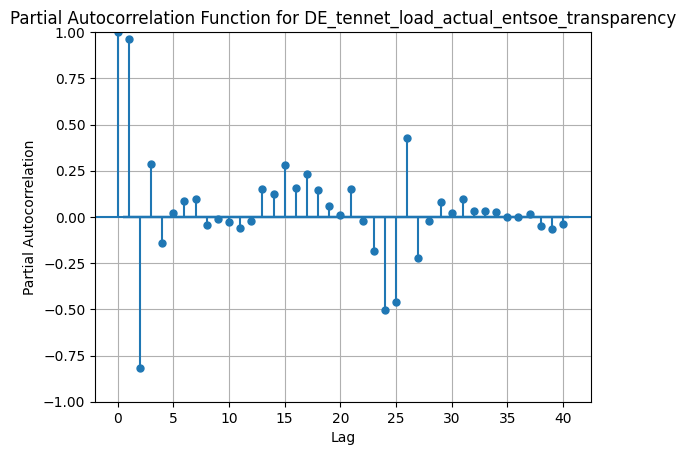

<Figure size 1200x400 with 0 Axes>

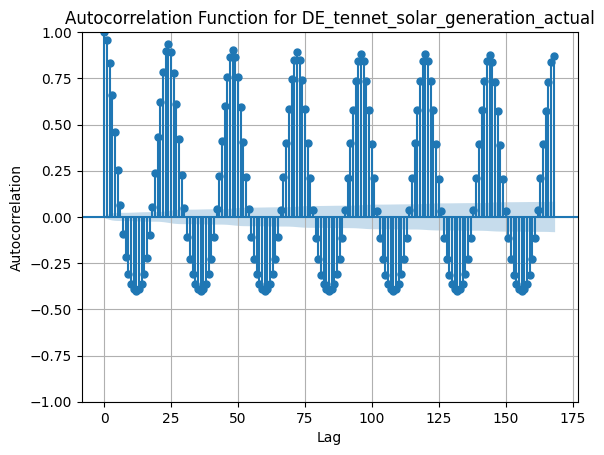

<Figure size 1200x400 with 0 Axes>

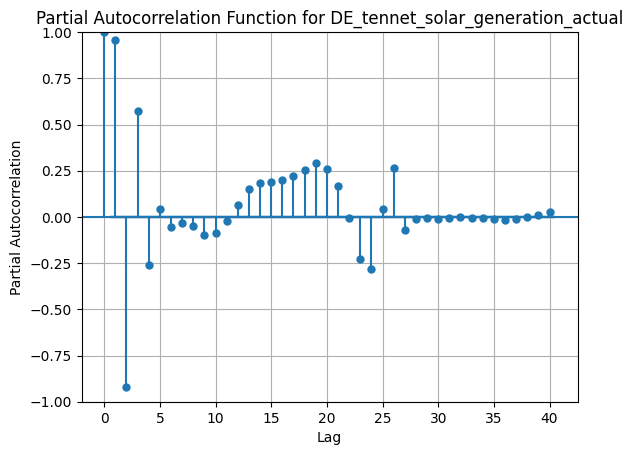

<Figure size 1200x400 with 0 Axes>

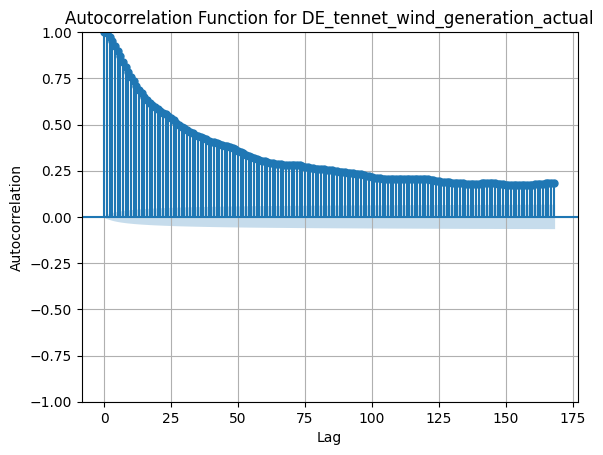

<Figure size 1200x400 with 0 Axes>

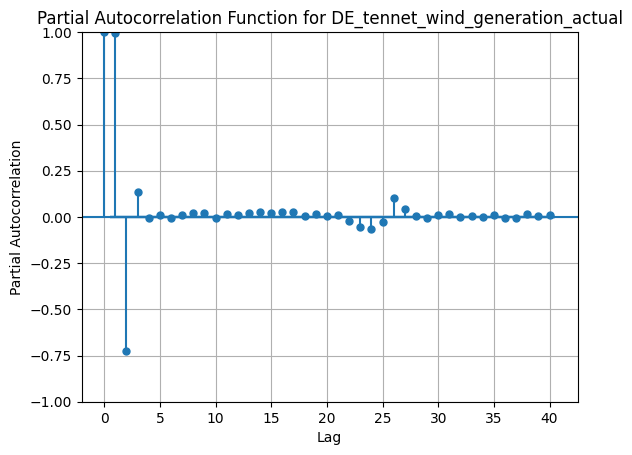

<Figure size 1200x400 with 0 Axes>

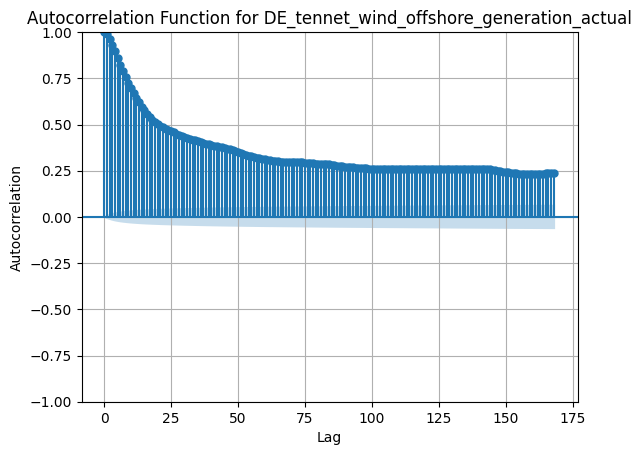

<Figure size 1200x400 with 0 Axes>

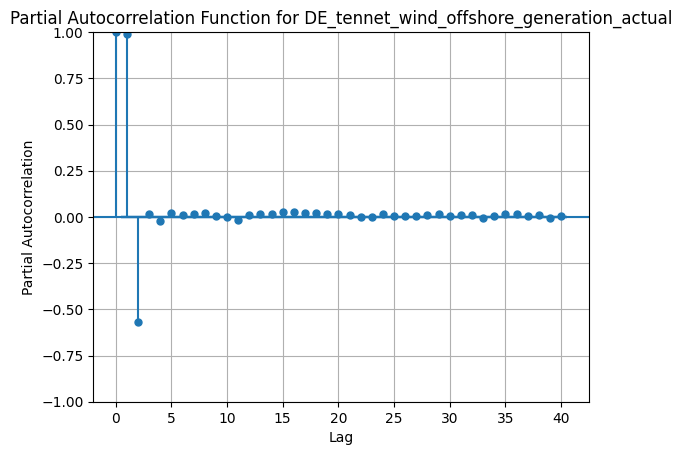

<Figure size 1200x400 with 0 Axes>

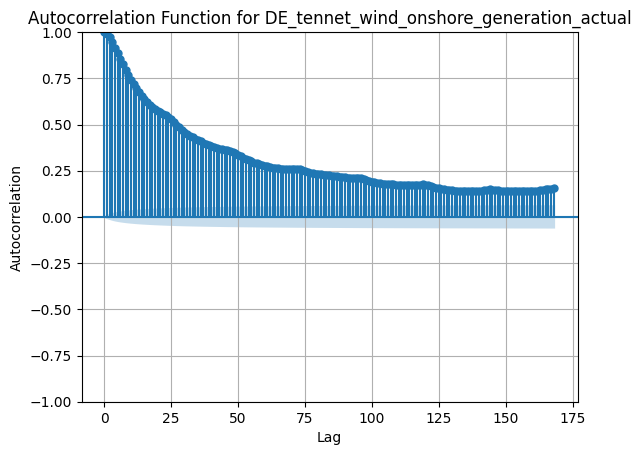

<Figure size 1200x400 with 0 Axes>

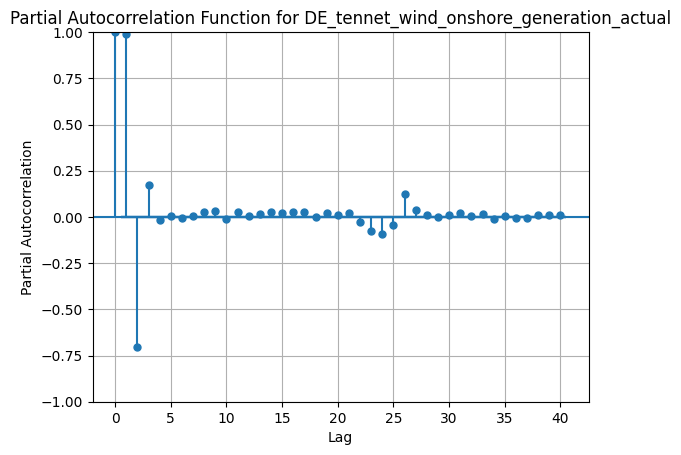

<Figure size 1200x400 with 0 Axes>

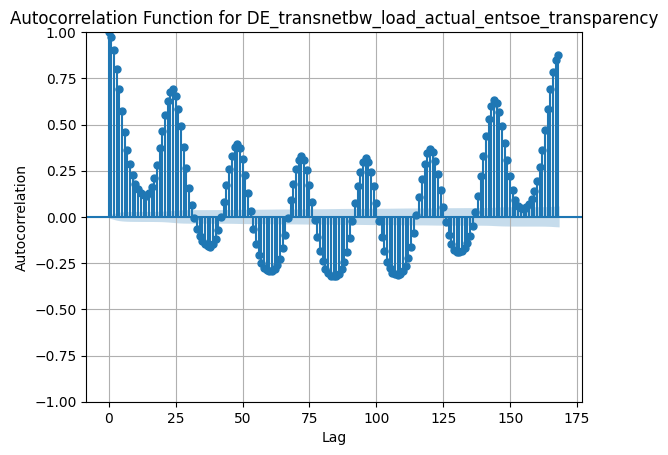

<Figure size 1200x400 with 0 Axes>

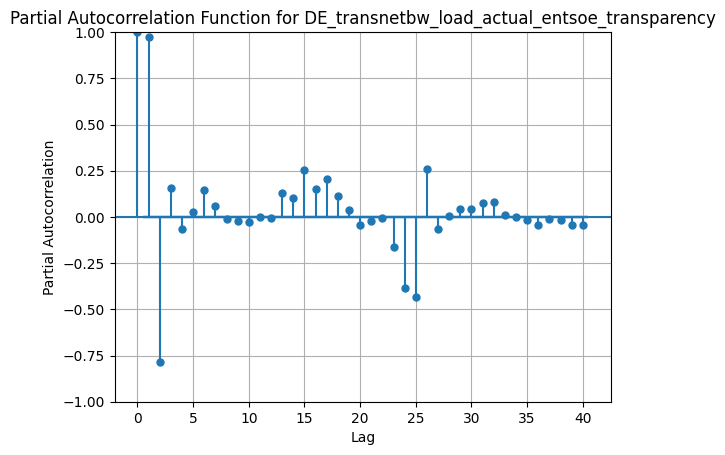

<Figure size 1200x400 with 0 Axes>

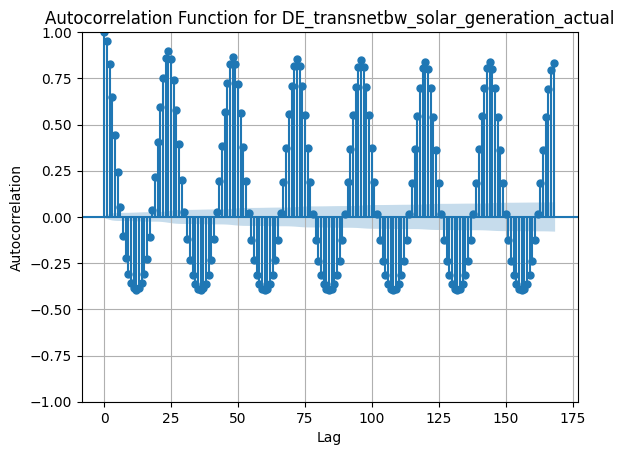

<Figure size 1200x400 with 0 Axes>

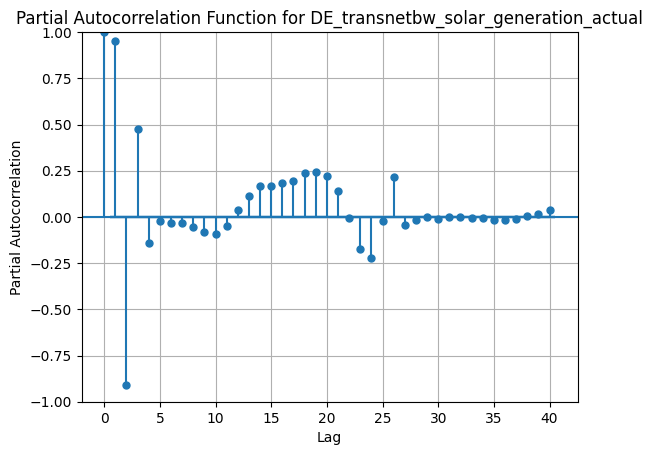

<Figure size 1200x400 with 0 Axes>

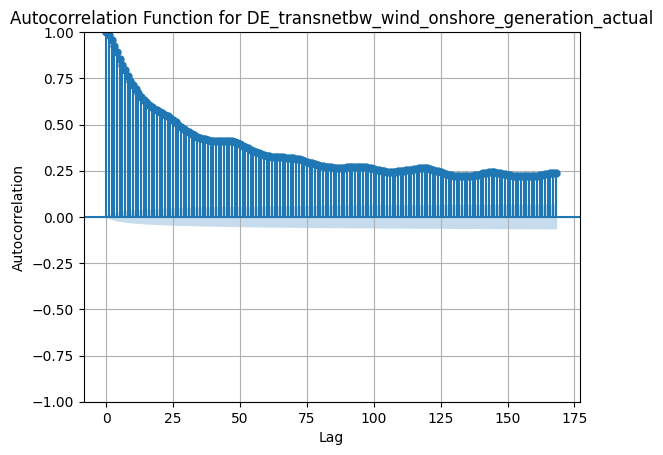

<Figure size 1200x400 with 0 Axes>

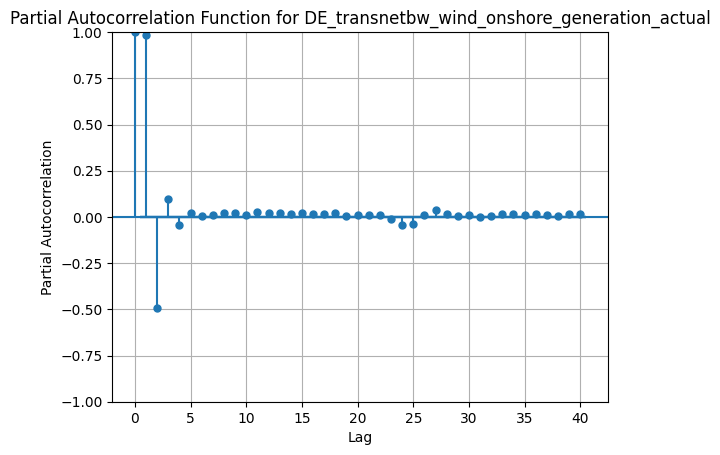

<Figure size 1200x400 with 0 Axes>

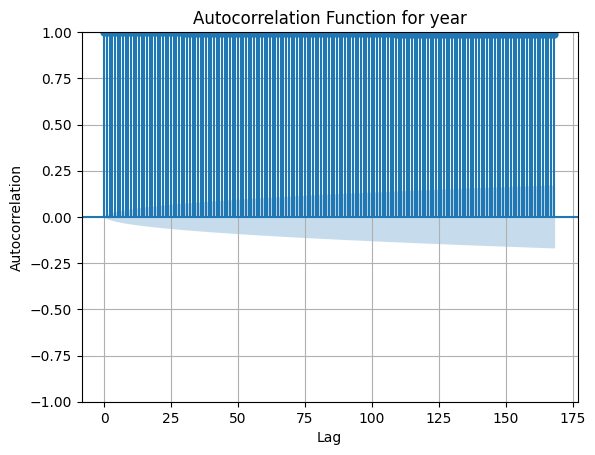

<Figure size 1200x400 with 0 Axes>

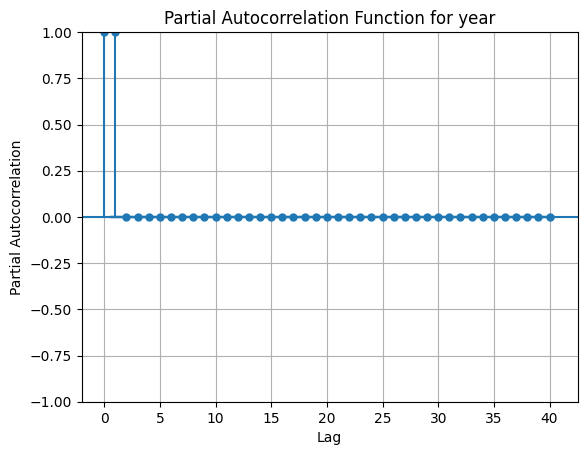

In [76]:
# Iterate through each column and plot ACF and PACF
for column_name in df.columns:
    # Plot autocorrelation function (ACF)
    plt.figure(figsize=(12, 4))
    plot_acf(df[column_name], lags=168, title=f'Autocorrelation Function for {column_name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

    # Plot partial autocorrelation function (PACF)
    plt.figure(figsize=(12, 4))
    plot_pacf(df[column_name], lags=40, title=f'Partial Autocorrelation Function for {column_name}')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.grid(True)
    plt.show()


/tmp/ipykernel_28020/807312276.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


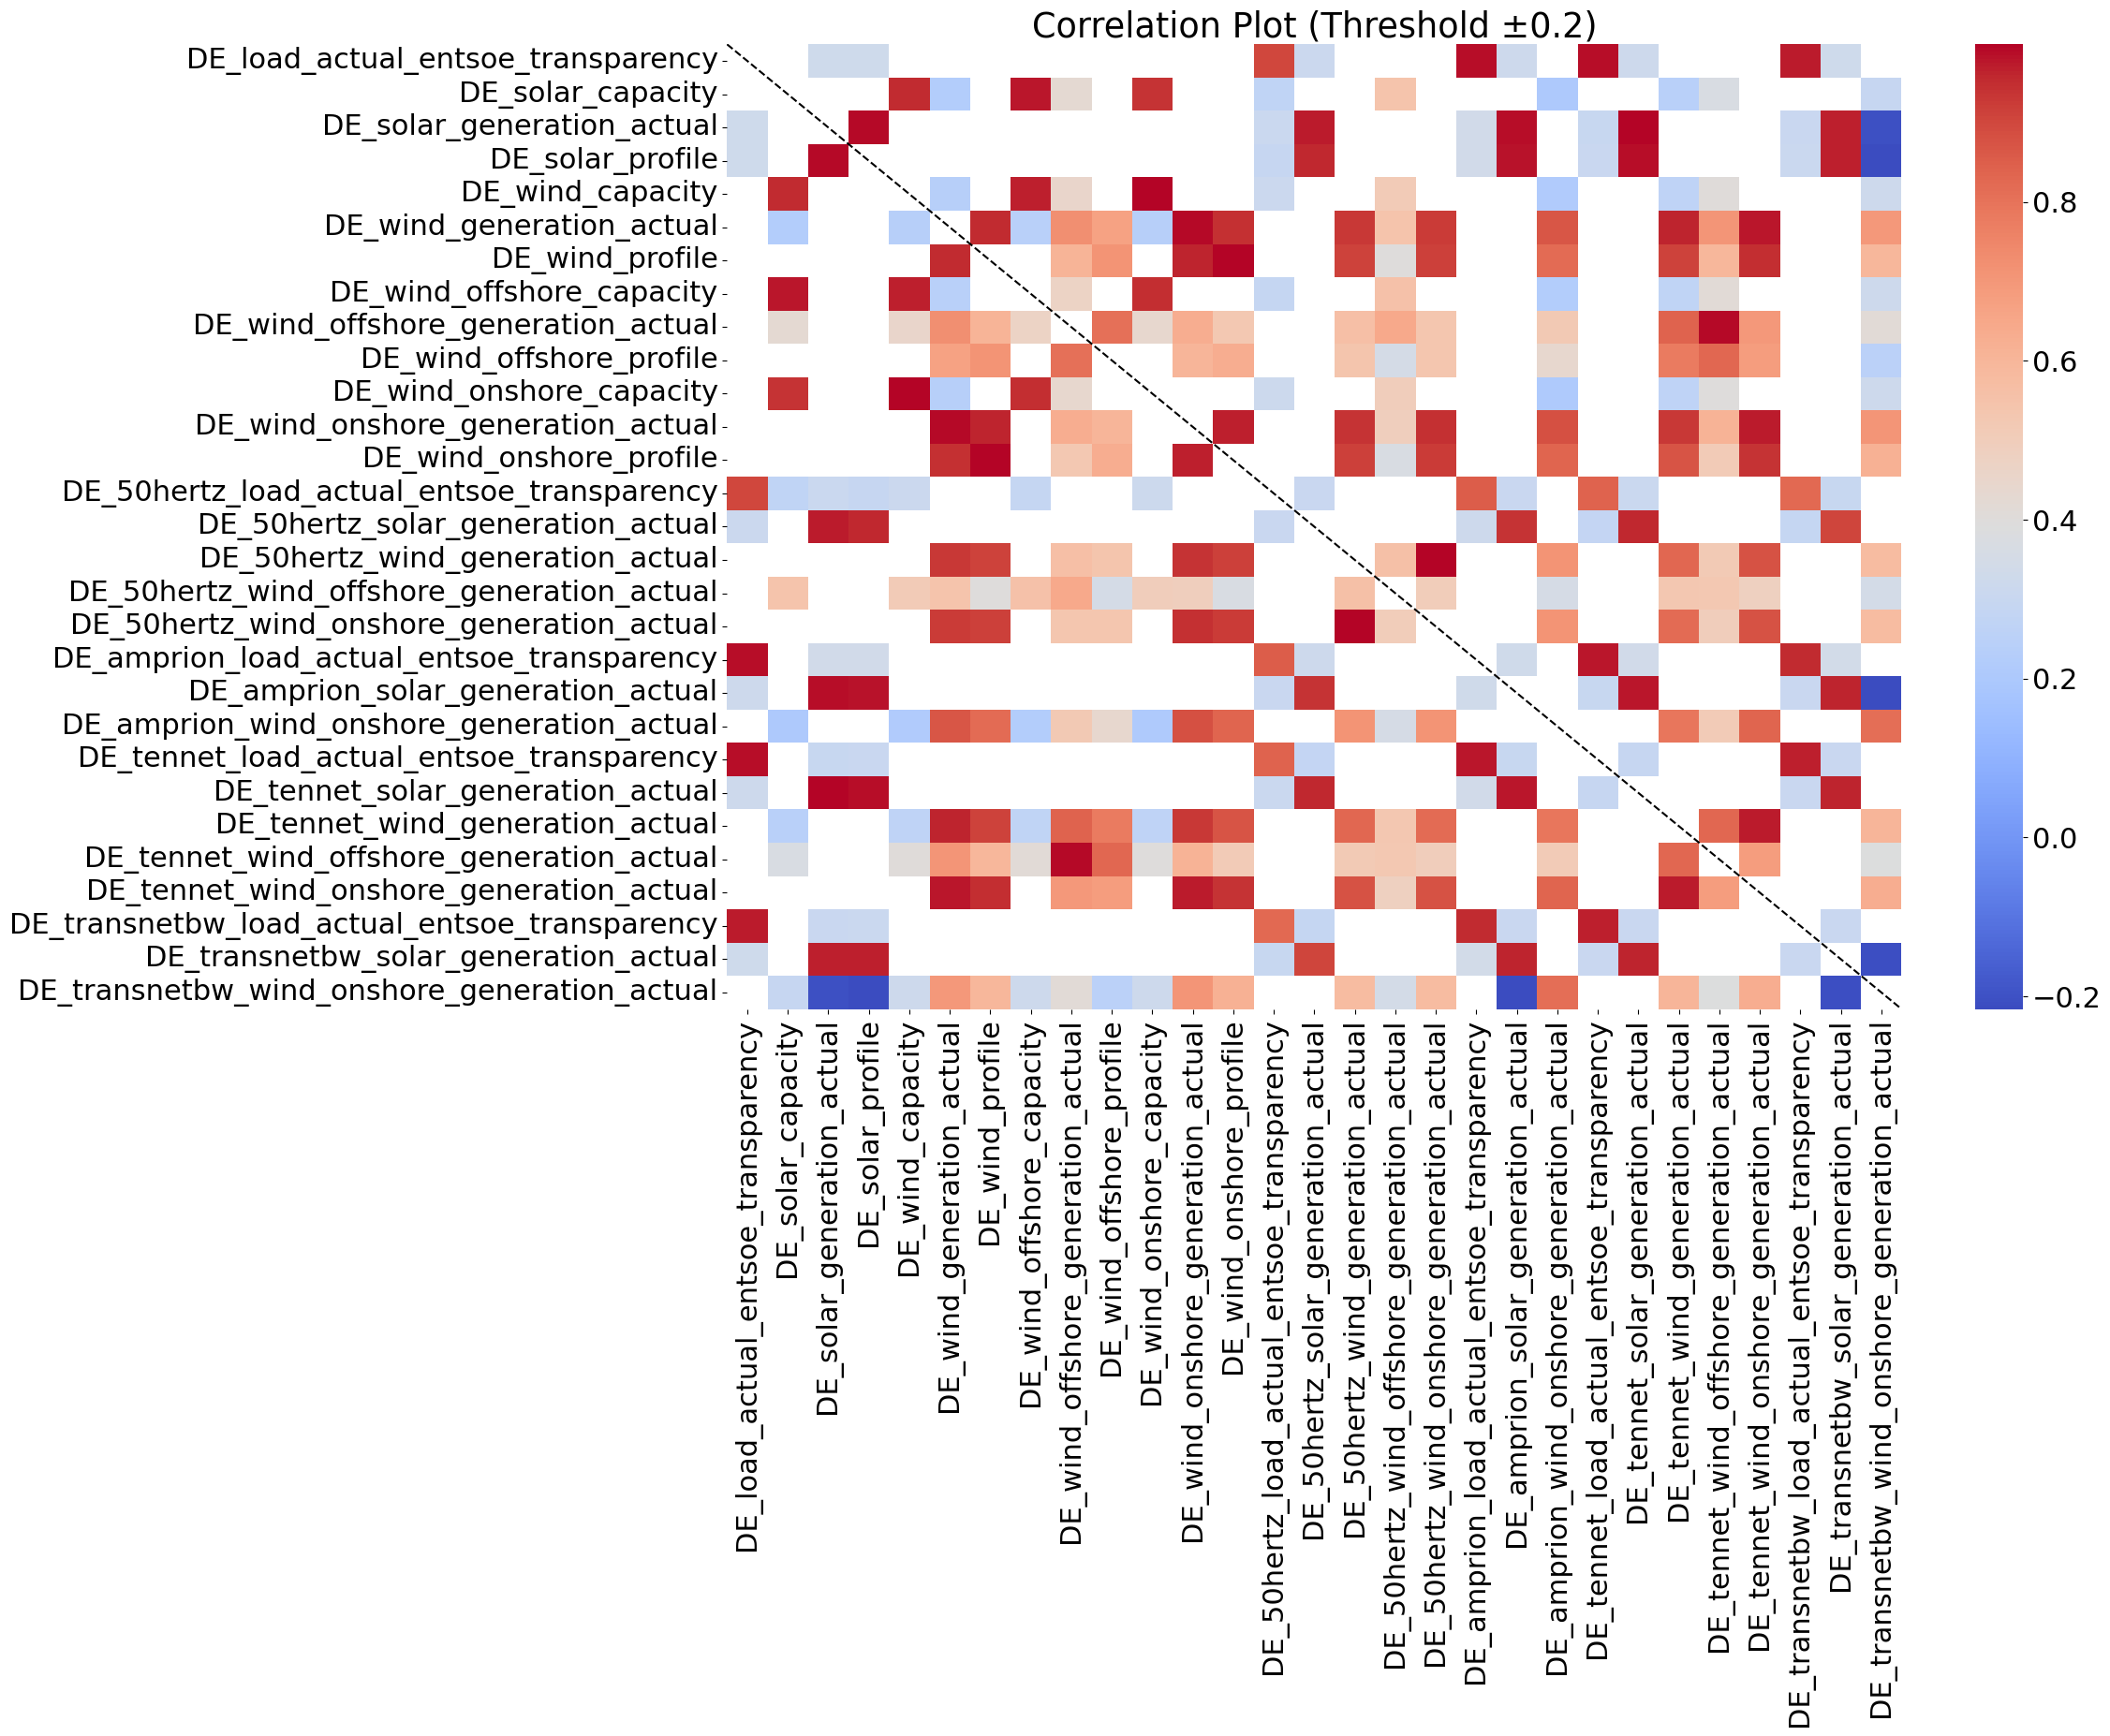

In [34]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Set the diagonal values to NaN
np.fill_diagonal(correlation_matrix.values, np.nan)

# Filter the correlation matrix to include only correlations above 0.2 or below -0.2
filtered_correlation_matrix = correlation_matrix[(correlation_matrix > 0.2) | (correlation_matrix < -0.2)]

plt.rcParams.update({'font.size': 22})  

# Create a heatmap of the filtered correlation matrix without numbers
plt.figure(figsize=(24, 19))

sns.heatmap(filtered_correlation_matrix, annot=False, cmap='coolwarm')

# Draw a diagonal line through self-correlation fields
plt.plot([0, filtered_correlation_matrix.shape[0]], [0, filtered_correlation_matrix.shape[0]], linestyle='--', color='black')

plt.title('Correlation Plot (Threshold ±0.2)')
plt.tight_layout()
plt.show()


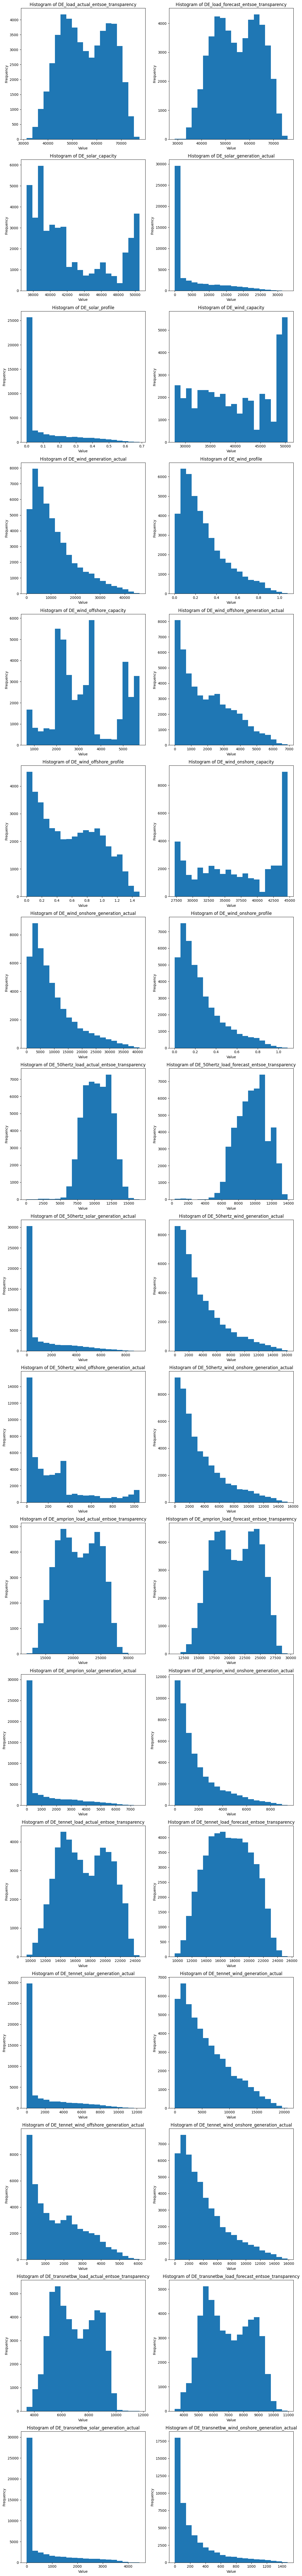

In [11]:
# Create a Histogram for each column
columns = df.columns
# Set up subplots for each histogram
num_columns = len(columns)
num_rows = (num_columns + 1) // 2  # Adjust the number of rows as needed

plt.figure(figsize=(12, 6 * num_rows))

for i, column in enumerate(columns, 1):
    plt.subplot(num_rows, 2, i)
    plt.hist(df[column], bins=20)  # Adjust the number of bins as needed
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

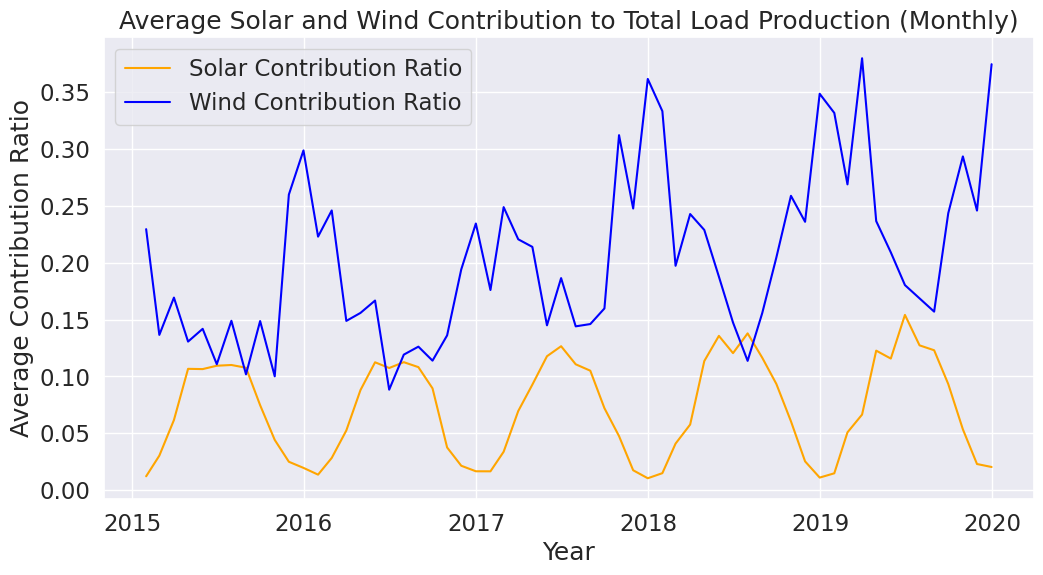

In [77]:
# Calculate the average ratio per month solar and wind energy contribution to total load
df['date'] = pd.to_datetime(df['date'])
df.index=df['date']
# Calculate the ratio of solar generation to total load production
df['Solar_Ratio'] = df['DE_solar_generation_actual'] / df['DE_load_actual_entsoe_transparency']

# Calculate the ratio of wind generation to total load production
df['Wind_Ratio'] = df['DE_wind_generation_actual'] / df['DE_load_actual_entsoe_transparency']

# Resample the data to monthly frequency and calculate the mean
monthly_ratios = df[['Solar_Ratio', 'Wind_Ratio']].resample('M').mean()

# Plot the subaggregated monthly ratios
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratios.index, monthly_ratios['Solar_Ratio'], label='Solar Contribution Ratio', color='orange')
plt.plot(monthly_ratios.index, monthly_ratios['Wind_Ratio'], label='Wind Contribution Ratio', color='blue')
plt.xlabel('Year')
plt.ylabel('Average Contribution Ratio')
plt.title('Average Solar and Wind Contribution to Total Load Production (Monthly)')
plt.legend()
plt.grid(True)
plt.show()

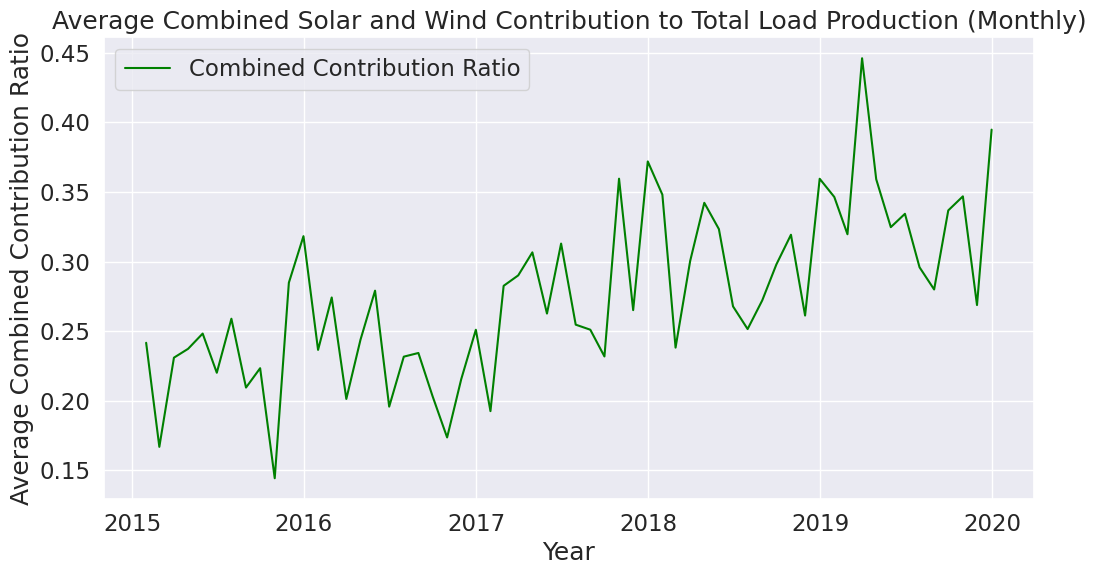

In [78]:
# Calculate the combined ratio of solar and wind energy contribution to total load
df['Combined_Ratio'] = (df['DE_solar_generation_actual'] + df['DE_wind_generation_actual']) / df['DE_load_actual_entsoe_transparency']

# Resample the data to monthly frequency and calculate the mean
monthly_ratios_2 = df[['Combined_Ratio']].resample('M').mean()

# Plot the subaggregated monthly combined ratio
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratios_2.index, monthly_ratios_2['Combined_Ratio'], label='Combined Contribution Ratio', color='green')
plt.xlabel('Year')
plt.ylabel('Average Combined Contribution Ratio')
plt.title('Average Combined Solar and Wind Contribution to Total Load Production (Monthly)')
plt.legend()
plt.grid(True)
plt.show()

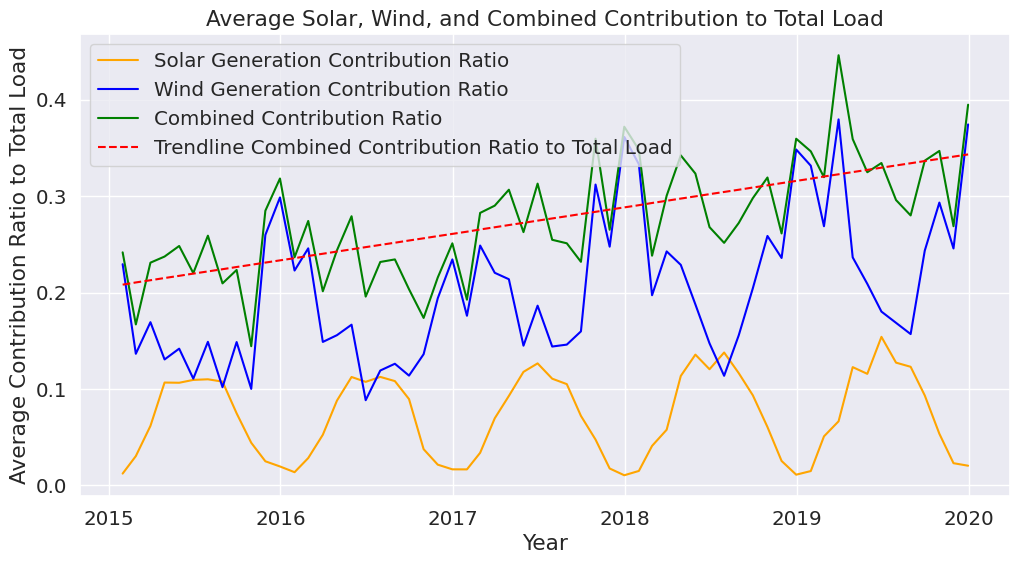

In [80]:
# Combine the above two plots in one plot and insert a trendline. 
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.3)
# Plot the Solar Contribution Ratio
plt.plot(monthly_ratios.index, monthly_ratios['Solar_Ratio'], label='Solar Generation Contribution Ratio', color='orange')

# Plot the Wind Contribution Ratio
plt.plot(monthly_ratios.index, monthly_ratios['Wind_Ratio'], label='Wind Generation Contribution Ratio', color='blue')

# Plot the Combined Contribution Ratio
plt.plot(monthly_ratios_2.index, monthly_ratios_2['Combined_Ratio'], label='Combined Contribution Ratio', color='green')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Contribution Ratio to Total Load')
plt.title('Average Solar, Wind, and Combined Contribution to Total Load')

# Add trend line for Combined Contribution Ratio
X = np.arange(len(monthly_ratios_2)).reshape(-1, 1)
y = monthly_ratios_2['Combined_Ratio'].values.reshape(-1, 1)
model = LinearRegression().fit(X, y)
trend_line = model.predict(X)
plt.plot(monthly_ratios_2.index, trend_line, linestyle='dashed', label='Trendline Combined Contribution Ratio to Total Load', color='red')

plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Creating a heatmap of a feature over hour of the day and month or weekday
# Since, the data is in UTC timeformat we first adjust the timestamp to match the original German time 
# This includes adjusting for summer time (+2 hours) and winter time (+1 hour) according to this website https://www.zeitumstellung.de/zeitumstellung-historisch-archiv.html

df['date'] = pd.to_datetime(df['date'])

# Define the date ranges according 
range1 = (
    ((df['date'] >= '2015-03-29') & (df['date'] <= '2015-10-25')) |
    ((df['date'] >= '2016-03-27') & (df['date'] <= '2016-10-30')) |
    ((df['date'] >= '2017-03-26') & (df['date'] <= '2017-10-29')) |
    ((df['date'] >= '2018-03-25') & (df['date'] <= '2018-10-28')) |
    ((df['date'] >= '2019-03-31') & (df['date'] <= '2019-10-27'))
)

# Increase the hour by 2 for dates in range1, and by 1 for others
df['date_german_time'] = df['date'] + pd.DateOffset(hours=2)
df.loc[~range1, 'date_german_time'] += pd.DateOffset(hours=1)

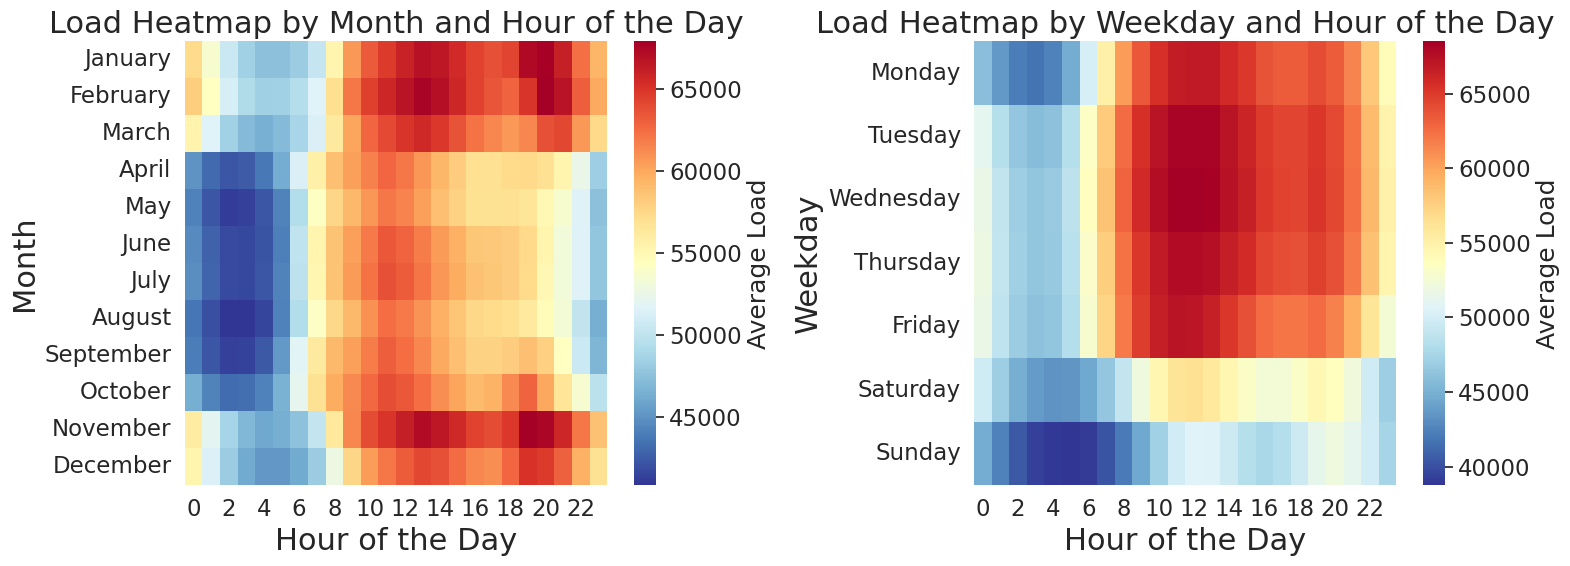

In [67]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set(font_scale=1.5)
# Plot the first heatmap (by month)
heatmap_data_month = df.pivot_table(values='DE_load_actual_entsoe_transparency',
                                    index='month', columns='hour', aggfunc='mean')
heatmap_data_month = heatmap_data_month.reindex(month_order)
vmin_month = heatmap_data_month.values.min()
vmax_month = heatmap_data_month.values.max()
sns.heatmap(heatmap_data_month, cmap='RdYlBu_r', vmin=vmin_month, vmax=vmax_month,
            annot=False, fmt=".2f", cbar_kws={'label': 'Average Load'}, ax=axes[0])
axes[0].set_xlabel('Hour of the Day', fontsize=22)
axes[0].set_ylabel('Month', fontsize=22)
axes[0].set_title('Load Heatmap by Month and Hour of the Day', fontsize=22)

# Plot the second heatmap (by weekday)
heatmap_data_weekday = df.pivot_table(values='DE_load_actual_entsoe_transparency',
                                      index='weekday', columns='hour', aggfunc='mean')

# Map numeric weekdays to actual names
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data_weekday.index = heatmap_data_weekday.index.map({i: name for i, name in enumerate(weekday_names)})

vmin_weekday = heatmap_data_weekday.values.min()
vmax_weekday = heatmap_data_weekday.values.max()

sns.heatmap(heatmap_data_weekday, cmap='RdYlBu_r', vmin=vmin_weekday, vmax=vmax_weekday,
            annot=False, fmt=".2f", cbar_kws={'label': 'Average Load'}, ax=axes[1])
axes[1].set_xlabel('Hour of the Day', fontsize=22)
axes[1].set_ylabel('Weekday', fontsize=22)
axes[1].set_title('Load Heatmap by Weekday and Hour of the Day', fontsize=22)

plt.tight_layout()
plt.show()


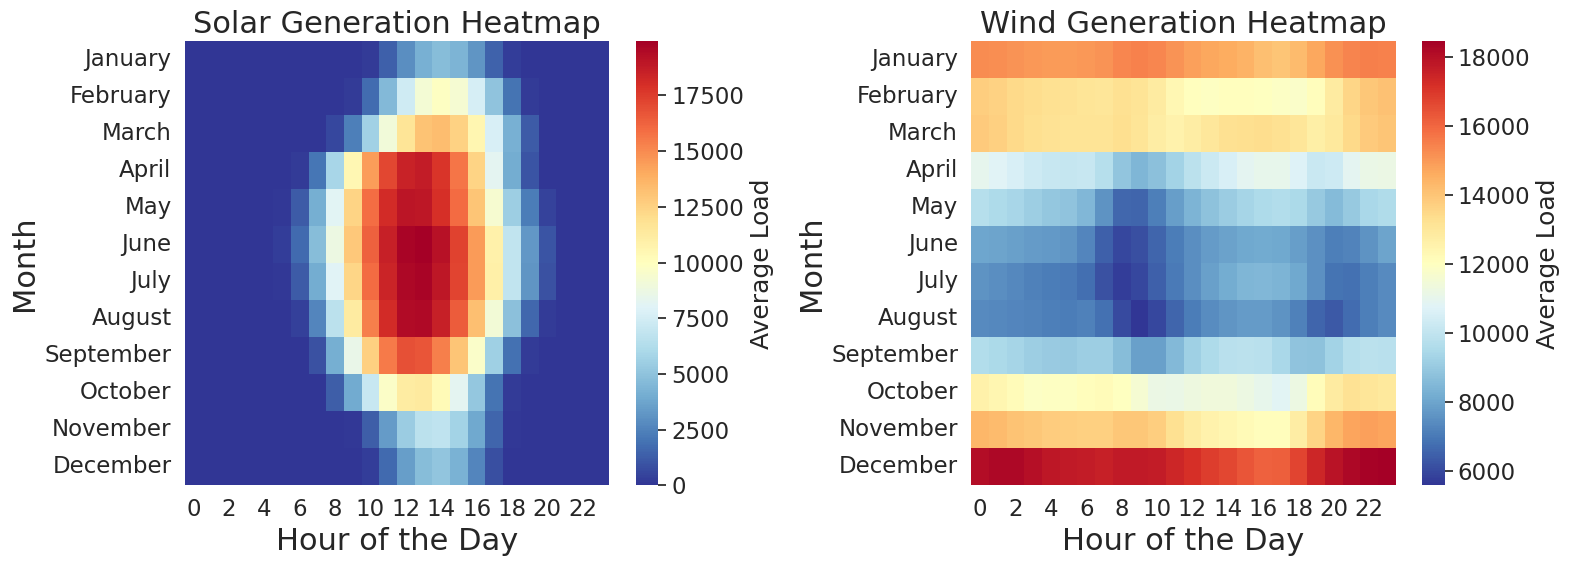

In [69]:
# This gives one heatmap for solar generation and one for wind generation per month
# Extract hour, month, and weekday
df['hour'] = df['date_german_time'].dt.hour
df['month'] = df['date_german_time'].dt.strftime('%B')  # Convert numeric month to month name
df['weekday'] = df['date_german_time'].dt.weekday  # Extract numeric weekday (Monday = 0, Sunday = 6)

# Define custom order for months and weekdays
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set(font_scale=1.5)
# Plot the first heatmap (by month)
heatmap_data_month = df.pivot_table(values='DE_solar_generation_actual',
                                    index='month', columns='hour', aggfunc='mean')
heatmap_data_month = heatmap_data_month.reindex(month_order)
vmin_month = heatmap_data_month.values.min()
vmax_month = heatmap_data_month.values.max()
sns.heatmap(heatmap_data_month, cmap='RdYlBu_r', vmin=vmin_month, vmax=vmax_month,
            annot=False, fmt=".2f", cbar_kws={'label': 'Average Load'}, ax=axes[0])
axes[0].set_xlabel('Hour of the Day', fontsize=22)
axes[0].set_ylabel('Month', fontsize=22)
axes[0].set_title('Solar Generation Heatmap', fontsize=22)

# Plot the second heatmap for wind generation (by month)
heatmap_data_month = df.pivot_table(values='DE_wind_generation_actual',
                                    index='month', columns='hour', aggfunc='mean')
heatmap_data_month = heatmap_data_month.reindex(month_order)
vmin_month = heatmap_data_month.values.min()
vmax_month = heatmap_data_month.values.max()
sns.heatmap(heatmap_data_month, cmap='RdYlBu_r', vmin=vmin_month, vmax=vmax_month,
            annot=False, fmt=".2f", cbar_kws={'label': 'Average Load'}, ax=axes[1])
axes[1].set_xlabel('Hour of the Day', fontsize=22)
axes[1].set_ylabel('Month', fontsize=22)
axes[1].set_title('Wind Generation Heatmap', fontsize=22)

plt.tight_layout()
plt.show()